### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [4]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [5]:
!python -m pip install --upgrade scikit-learn
import sklearn

In [6]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [7]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
import ast
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [8]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
# Load in the feature summary file.
azdias_feat = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [9]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Check How many Non-Null and  which Dtypes are in the dataset
azdias.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [10]:
azdias.shape

(891221, 85)

In [11]:
# Header preview
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
# How many missing values are in the dataset?
azdias.isna().sum()[azdias.isna().sum() > 0].sort_values(ascending=False).head(n=100)

KK_KUNDENTYP           584612
KBA05_GBZ              133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_ANTG1            133324
KBA05_ANTG2            133324
MOBI_REGIO             133324
KBA05_BAUMAX           133324
KKK                    121196
REGIOTYP               121196
PLZ8_ANTG2             116515
PLZ8_ANTG3             116515
PLZ8_BAUMAX            116515
PLZ8_GBZ               116515
PLZ8_HHZ               116515
PLZ8_ANTG4             116515
PLZ8_ANTG1             116515
W_KEIT_KIND_HH         107602
KBA13_ANZAHL_PKW       105800
CAMEO_DEUG_2015         98979
CAMEO_INTL_2015         98979
CAMEO_DEU_2015          98979
ORTSGR_KLS9             97216
ARBEIT                  97216
RELAT_AB                97216
ANZ_HH_TITEL            97008
EWDICHTE                93740
INNENSTADT              93740
BALLRAUM                93740
GEBAEUDETYP_RASTER      93155
ANZ_HAUSHALTE_AKTIV     93148
GEBAEUDETYP             93148
WOHNLAGE                93148
MIN_GEBAEU

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Identify missing or unknown data values and convert them to NaNs.

# Replace missing values with numpy NaN
def nan_missing_val(azdias_subset, azdias_feature_summary):
    # Ensure alignment of columns between the two dataframes
    matching_columns = azdias_subset.columns.intersection(azdias_feature_summary["attribute"])
    for col in matching_columns:
        # Extract the missing_or_unknown values for the column
        missing_values = azdias_feature_summary.loc[azdias_feature_summary["attribute"] == col, "missing_or_unknown"].iloc[0]

        try:
            # Safely parse the missing values as a Python list
            missing_values_list = ast.literal_eval(missing_values)
        except (ValueError, SyntaxError):
            # Fallback: Split by commas if the string isn"t a valid list
            missing_values_list = missing_values.split(",")

        # Ensure all values are stripped of whitespace and converted to strings
        missing_values_list = [str(value).strip() for value in missing_values_list]

        # Replace these values with NaN in the azdias_subset
        azdias_subset[col] = azdias_subset[col].astype(str).replace(missing_values_list, np.nan)
        azdias_subset.replace("nan", np.nan, inplace=True)
        return  azdias_subset

azdias_p = nan_missing_val(azdias, azdias_feat)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

# How much data is missing in each **column** of the dataset?

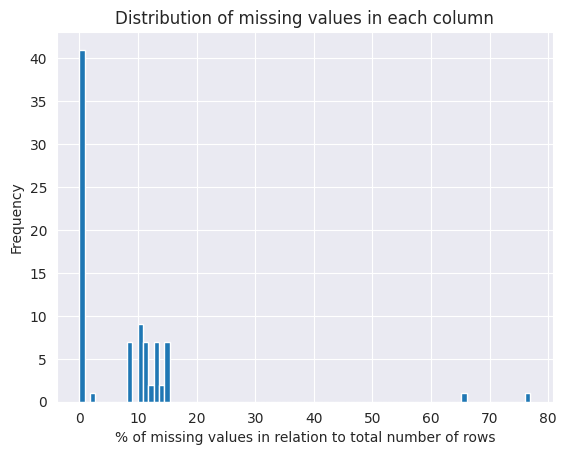

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# How many missing values are in each column?
nan_col_mask = azdias_p.isna().sum()
c_name_miss_in_p = (nan_col_mask.sort_values(ascending=False) / azdias_p.shape[0]) * 100

## Count the frequency (how many times the same amount of missing values are occurring in different columns) of missing values and plot vs missing values
plt.hist(c_name_miss_in_p, bins=len(c_name_miss_in_p))
# Add axis labels
plt.title("Distribution of missing values in each column")
plt.xlabel("% of missing values in relation to total number of rows")  # Label for the x-axis
plt.ylabel("Frequency")  # how many columns missing the same amount of values
# Display the plot
plt.show()

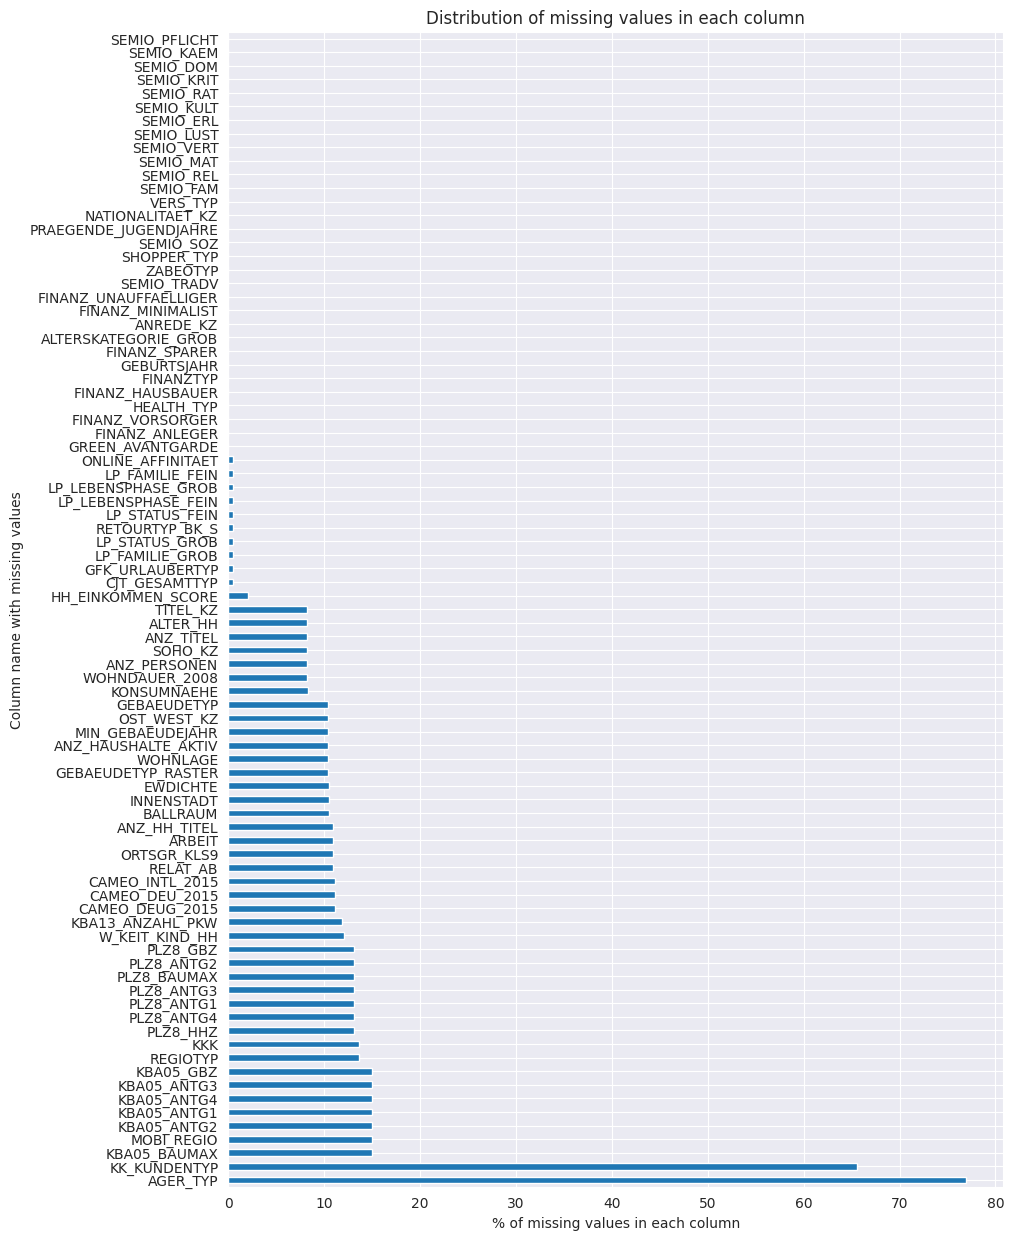

In [15]:
# Investigate patterns in the amount of missing data in each column.
c_name_miss_in_p.plot.barh(figsize=(10, 15), title="Distribution of missing values in each column")
plt.xlabel("% of missing values in each column")
plt.ylabel("Column name with missing values")
plt.show()

In [16]:
# Threshold for filtering columns with missing values in percent
def mask_col_with_missing_values(c_miss_name_val, c_miss_threshold):
    no_missing = c_miss_name_val[c_miss_name_val == 0]
    lower_than_threshold = c_miss_name_val[(c_miss_name_val <= c_miss_threshold) & (c_miss_name_val != 0)]
    higher_than_threshold = c_miss_name_val[c_miss_name_val > c_miss_threshold]
    print(f"----{no_missing.shape[0]} column/s no missing values n = 0.0%----\n{no_missing.sort_values(ascending=False)}")
    print(f"----{lower_than_threshold.shape[0]} column/s with missing values 0 < n <= {c_miss_threshold:.1f}%----\n{lower_than_threshold.sort_values(ascending=False)}")
    print(f"----{higher_than_threshold.shape[0]} column/s with missing values > {c_miss_threshold:.1f}%----\n{higher_than_threshold.sort_values(ascending=False)}")
    return no_missing, lower_than_threshold, higher_than_threshold

# Based on number of missing values in column: dividing the data into two subsets, subset that is below threshold and subset that is above threshold
c_miss_threshold = 15   # in %
no_missing, c_name_low_miss, c_name_high_miss = mask_col_with_missing_values(c_name_miss_in_p, c_miss_threshold)


----31 column/s no missing values n = 0.0%----
GREEN_AVANTGARDE         0.0
FINANZ_ANLEGER           0.0
FINANZ_VORSORGER         0.0
HEALTH_TYP               0.0
FINANZ_HAUSBAUER         0.0
FINANZTYP                0.0
GEBURTSJAHR              0.0
FINANZ_SPARER            0.0
ALTERSKATEGORIE_GROB     0.0
ANREDE_KZ                0.0
FINANZ_MINIMALIST        0.0
FINANZ_UNAUFFAELLIGER    0.0
SEMIO_TRADV              0.0
ZABEOTYP                 0.0
SHOPPER_TYP              0.0
SEMIO_SOZ                0.0
PRAEGENDE_JUGENDJAHRE    0.0
NATIONALITAET_KZ         0.0
VERS_TYP                 0.0
SEMIO_FAM                0.0
SEMIO_REL                0.0
SEMIO_MAT                0.0
SEMIO_VERT               0.0
SEMIO_LUST               0.0
SEMIO_ERL                0.0
SEMIO_KULT               0.0
SEMIO_RAT                0.0
SEMIO_KRIT               0.0
SEMIO_DOM                0.0
SEMIO_KAEM               0.0
SEMIO_PFLICHT            0.0
dtype: float64
----52 column/s with missing values 0 <

In [19]:
# Get a list of column names to drop
drop_col_list = c_name_high_miss.index.tolist()   # list with column names to drop
print(drop_col_list)
# Drop the columns from the DataFrame
try:
    azdias_p = azdias_p.drop(columns=drop_col_list)
    print(drop_col_list)
except KeyError:
    print(f"Columns {drop_col_list} not found in dataset or may have already been dropped.")


['AGER_TYP', 'KK_KUNDENTYP']
Columns ['AGER_TYP', 'KK_KUNDENTYP'] not found in dataset or may have already been dropped.


In [20]:
# Drop the columns as well from the feature summary
azdias_feat_lower_threshold = azdias_feat[azdias_feat["attribute"].isin(azdias_p.columns.tolist())]
print(f"Columns dropped from `azdias_feat`:\n"
      f"`Feature summary DataFrame` shape before drop: {azdias.shape}\n"
      f"`Feature summary DataFrame` shape after  drop: {azdias_p.shape}\n"
      f"------------------{c_name_high_miss.shape[0]} dropped column/s:------------------\n"
      f"---------------- n missing values in % ----------------\n"
      f"{c_name_high_miss.sort_values(ascending=False)}")


Columns dropped from `azdias_feat`:
`Feature summary DataFrame` shape before drop: (891221, 85)
`Feature summary DataFrame` shape after  drop: (891221, 83)
------------------2 dropped column/s:------------------
---------------- n missing values in % ----------------
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
dtype: float64


#### Discussion 1.1.2: Assess Missing Data in Each Column

Sorted list of column names with missing values:

`'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'MOBI_REGIO', 'KBA05_ANTG2', 'KBA05_ANTG1', 'KBA05_ANTG4', 'KBA05_ANTG3', 'KBA05_GBZ', 'REGIOTYP', 'KKK', 'PLZ8_HHZ', 'PLZ8_ANTG4', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', PLZ8_ANTG2', 'PLZ8_GBZ', 'W_KEIT_KIND_HH', 'KBA13_ANZAHL_PKW', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'RELAT_AB', 'ORTSGR_KLS9', 'ARBEIT', 'ANZ_HH_TITEL', 'BALLRAUM', 'INNENSTADT', 'EWDICHTE', GEBAEUDETYP_RASTER', 'WOHNLAGE', 'ANZ_HAUSHALTE_AKTIV', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'GEBAEUDETYP', 'KONSUMNAEHE', 'WOHNDAUER_2008', 'ANZ_PERSONEN', 'SOHO_KZ', 'ANZ_TITEL', 'ALTER_HH', 'TITEL_KZ', HH_EINKOMMEN_SCORE', 'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'LP_STATUS_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'ONLINE_AFFINITAET'`

Highest amount of missing/unknown values are in columns:


(`AGER_TYP` belongs to `Person-level features`; `KK_KUNDENTYP` belongs to `Household-level features` and describes consumer pattern over past 12 months.)

`AGER_TYP = 77%, KK_KUNDENTYP = 66%`
Based on that high amonut of missing values, we should remove these columns from the dataset.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

# How many missing values are in each row?

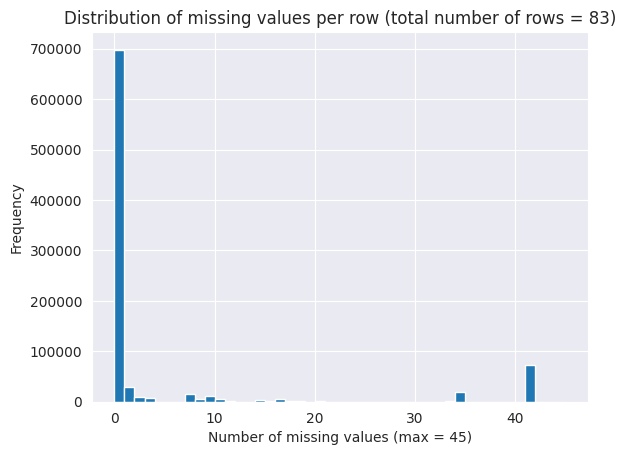

In [21]:
# Calculate the number of missing values in each row (NOT in percent as before was done for columns)
azdias_missing_rows = azdias_p.isna().sum(axis=1)

# Visualize the distribution of the number of missing values in each row
plt.hist(azdias_missing_rows, bins=azdias_missing_rows.max())
plt.title("Distribution of missing values per row (total number of rows = {0})".format(azdias_p.shape[1]))
plt.xlabel(f"Number of missing values (max = {azdias_missing_rows.max()})")  # Label for the x-axis
plt.ylabel("Frequency")  # how many columns missing the same amount of values
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

def divide_data_by_missing_values(data, threshold):
    subset_no_missing = data[data.isna().sum(axis=1) == 0]
    subset_low_missing = data[(data.isna().sum(axis=1) <= threshold) & (data.isna().sum(axis=1) != 0)]   # Calculate the number of missing values per row & compare with threshold
    subset_high_missing = data[data.isna().sum(axis=1) > threshold]

    return subset_no_missing, subset_low_missing, subset_high_missing  # Divide data into two subsets

# Set a threshold value for the number of missing values in each row.
threshold_rows = 10
subset_no_missing, subset_low_missing, subset_high_missing = divide_data_by_missing_values(azdias_p, threshold_rows)

def print_summary_miissing_rows(azdias_p, threshold_rows, subset_no_missing, subset_low_missing, subset_high_missing):

    # number of missing rows
    n_row = azdias_p.shape[0]
    n_row_no_missing = subset_no_missing.shape[0]
    n_row_low_missing = subset_low_missing.shape[0]
    n_row_high_missing = subset_high_missing.shape[0]

    # number of missing rows in percent
    n_row_p = (n_row_no_missing / n_row_no_missing) * 100
    n_row_no_missing_p = (n_row_no_missing / n_row) * 100
    n_row_low_missing_p = (n_row_low_missing / n_row) * 100
    n_row_high_missing_p = (n_row_high_missing / n_row) * 100

    # number of missing values
    n_nan_val = azdias_p.isna().sum(axis=1).sum()
    n_nan_val_no_missing = subset_no_missing.isna().sum(axis=1).sum()
    n_nan_val_low_missing = subset_low_missing.isna().sum(axis=1).sum()
    n_nan_val_high_missing = subset_high_missing.isna().sum(axis=1).sum()

    # number of missing values in percent
    n_nan_val_p = 100
    n_nan_val_no_missing_p = (n_nan_val_no_missing / n_nan_val) * 100
    n_nan_val_low_missing_p = (n_nan_val_low_missing / n_nan_val) * 100
    n_nan_val_high_missing_p = (n_nan_val_high_missing / n_nan_val) * 100

    print(
      f"---- General stat. ----\n"
      f"Maximum number of missing values in a row: {azdias_p.isna().sum(axis=1).max()}\n"
      f"Threshold of missing values per rows: {threshold_rows}\n"
      f"Sum of rows in df: {n_row} = {n_row_p:.1f}%\n"
      f"Sum of total missing values in all rows: {n_nan_val} = {n_nan_val_p:.1f}%\n\n"
      f"---- df_subset without missing values ----\n"
      f"n rows: {n_row_no_missing} = {n_row_no_missing_p:.1f}%\n"
      f"Sum of missing values per rows in subset_no_missing: {n_nan_val_no_missing} = {n_nan_val_no_missing_p:.1f}%\n\n"
      f"---- df_subset with 0 > n missing values <= {threshold_rows} ----\n"
      f"n rows: {n_row_low_missing} = {n_row_low_missing_p:.1f}%\n"
      f"Sum of missing values per rows in subset_low_missing: {n_nan_val_low_missing} = {n_nan_val_low_missing_p:.1f}%\n\n"
      f"---- df_subset with > {threshold_rows} missing values ----\n"
      f"n rows: {n_row_high_missing} = {n_row_high_missing_p:.1f}%\n"
      f"Sum of missing values per rows in subset_high_missing: {n_nan_val_high_missing} = {n_nan_val_high_missing_p:.1f}%\n")

print_summary_miissing_rows(azdias_p, threshold_rows, subset_no_missing, subset_low_missing, subset_high_missing)

---- General stat. ----
Maximum number of missing values in a row: 45
Threshold of missing values per rows: 10
Sum of rows in df: 891221 = 100.0%
Sum of total missing values in all rows: 4312226 = 100.0%

---- df_subset without missing values ----
n rows: 697859 = 78.3%
Sum of missing values per rows in subset_no_missing: 0 = 0.0%

---- df_subset with 0 > n missing values <= 10 ----
n rows: 85221 = 9.6%
Sum of missing values per rows in subset_low_missing: 391563 = 9.1%

---- df_subset with > 10 missing values ----
n rows: 108141 = 12.1%
Sum of missing values per rows in subset_high_missing: 3920663 = 90.9%



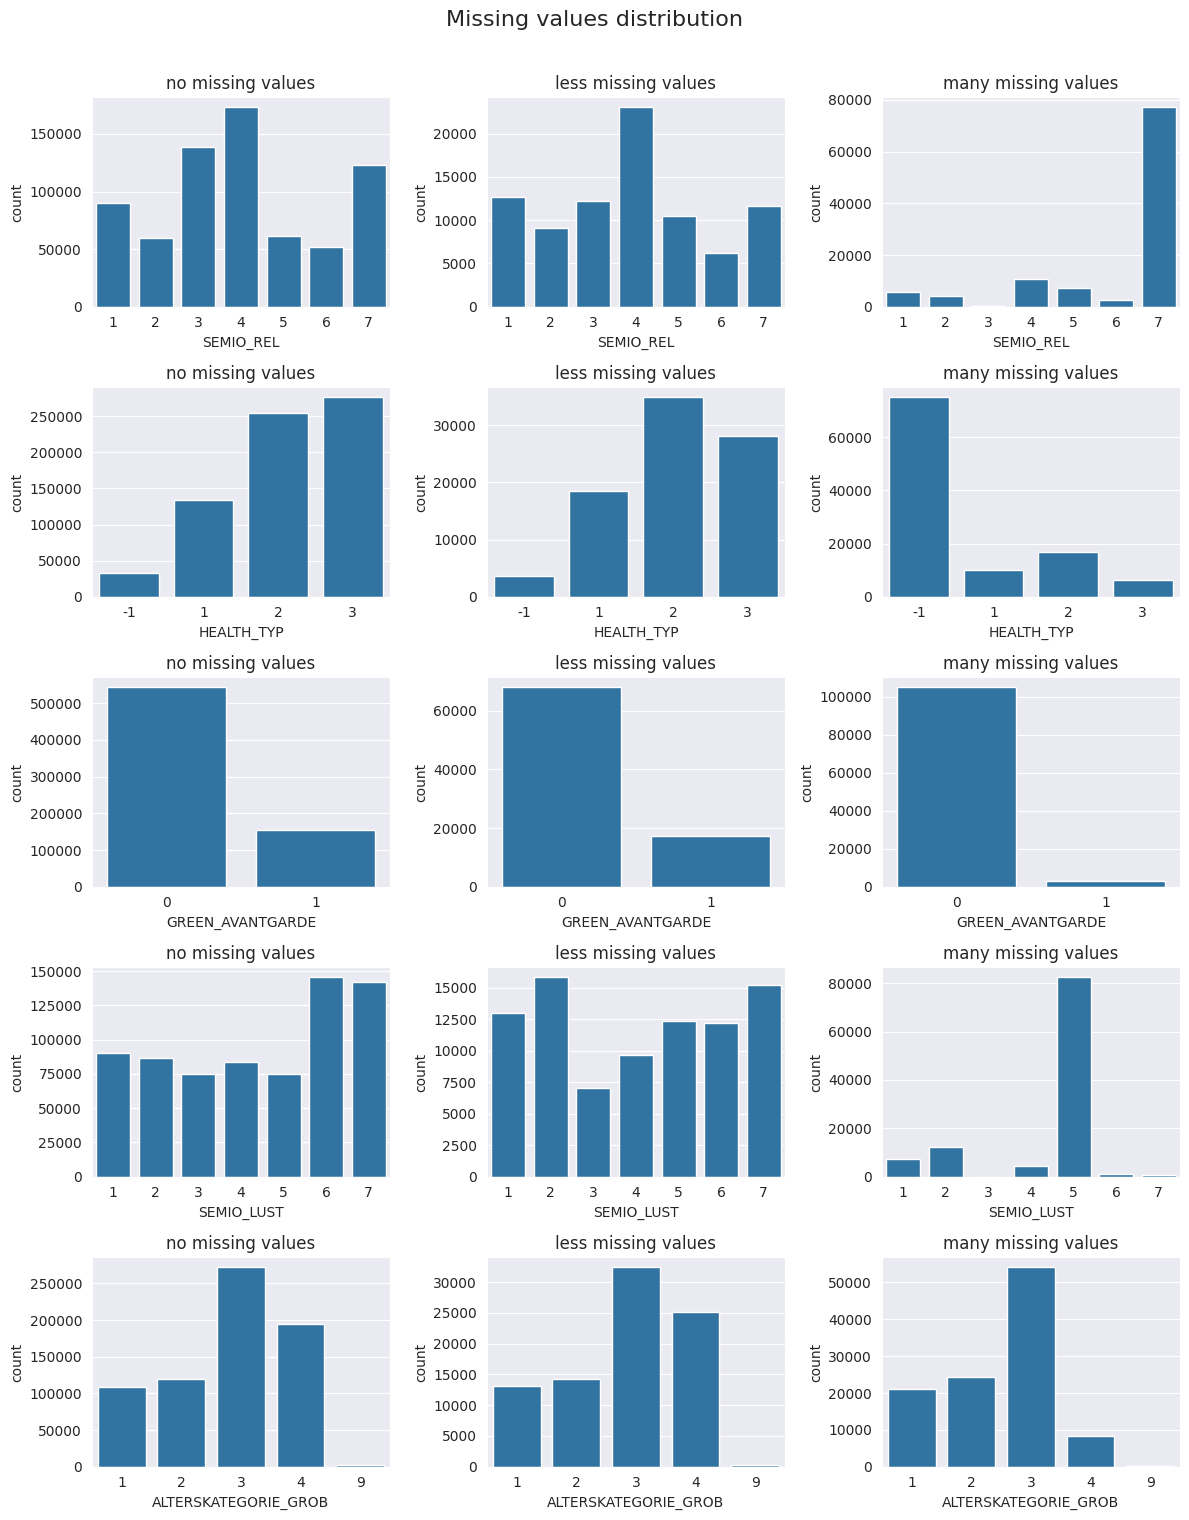

In [25]:
random.seed(42)
n_plots = 5    # select how many columns to plot/compare with each other
no_miss_c_list = no_missing.index.tolist()
no_miss_c_list_rand = random.sample(no_miss_c_list, n_plots)

# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Create the subplots side by side
fig, axes = plt.subplots(n_plots, 3, figsize=(12, (n_plots*3)), sharey=False)

# Loop through each subplot row
for row_idx, i in enumerate(no_miss_c_list_rand):
    # First subplot: Frequencies of code_group1
    sns.countplot(x=subset_no_missing[i], data=subset_no_missing, ax=axes[row_idx, 0])
    axes[row_idx, 0].set_title("no missing values")

    # Second subplot: Frequencies of code_group2
    sns.countplot(x=subset_low_missing[i], data=subset_low_missing, ax=axes[row_idx, 1])
    axes[row_idx, 1].set_title("less missing values")

    # Third subplot: Frequencies of code_group3
    sns.countplot(x=subset_high_missing[i], data=subset_high_missing, ax=axes[row_idx, 2])
    axes[row_idx, 2].set_title("many missing values")

# Add an overall title
plt.suptitle("Missing values distribution", fontsize=16, y=1.01)

# Adjust layout and display
plt.tight_layout()
plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

To distinguish between rows that have many or low number of missing column data, I use a threshold of `10`.
- If a row has 0 missing values, it is considered to have **no missing values**.
- If a row has <= 10 but > 0 missing values, it is considered to have **low missing values**.
- If a row has > 10 missing values, it is considered to have **many missing values**.

The data has been splitted in three subsets: `subset_no_missing`, `subset_low_missing` and `subset_high_missing`.
Using seaborn's `countplot` I compared the distribution of values for at least five columns where there are no, few, and many missing values between the three subsets.
The rows with many missing values are qualitatively different from the rows with few or no missing values.
Later on it has to be considered during evaluation.

The rows with no and low missing values are qualitatively similar distribution, which is expected because the data is clean.
Both subsets are used in the next step.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and "mixed".

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

# Combine the two subsets

In [26]:
combined_df = pd.concat([subset_no_missing, subset_low_missing], ignore_index=True)
# How many features are there of each data type?

azdias_feat_lower_threshold[["attribute", "type"]].groupby("type").count().sort_values("attribute", ascending=False)


,attribute
type,
ordinal,49
categorical,19
mixed,7
numeric,7
interval,1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def classify_categorical_features(combined_df, feat_summ) -> dict:
    """
    Classify features as binary, multi-valued, or non-numeric.
    """
    # Extract categorical columns from the summary
    categorical_columns = feat_summ[feat_summ["type"] == "categorical"]["attribute"]

    # Initialize results
    features = {"binary": [], "multi": [], "non_numeric": []}

    # Classify features as binary, multi-valued, or non-numeric
    for col in categorical_columns:
        if not pd.api.types.is_numeric_dtype(combined_df[col]):
            # If the column is non-numeric, classify it as non_numeric
            features["non_numeric"].append([col, combined_df[col].nunique()])
        else:
            # Otherwise, classify based on unique value count
            unique_count = combined_df[col].nunique()
            if unique_count <= 2:
                features["binary"].append([col, unique_count])
            else:
                features["multi"].append([col, unique_count])

    return features

feat_categor = classify_categorical_features(combined_df, azdias_feat_lower_threshold[["attribute", "type"]])
pprint.pprint(feat_categor)

{'binary': [['ANREDE_KZ', 2], ['GREEN_AVANTGARDE', 2], ['SOHO_KZ', 2]],
 'multi': [['CJT_GESAMTTYP', 6],
           ['FINANZTYP', 6],
           ['GFK_URLAUBERTYP', 12],
           ['LP_FAMILIE_FEIN', 12],
           ['LP_FAMILIE_GROB', 6],
           ['LP_STATUS_FEIN', 10],
           ['LP_STATUS_GROB', 5],
           ['NATIONALITAET_KZ', 4],
           ['SHOPPER_TYP', 5],
           ['TITEL_KZ', 6],
           ['VERS_TYP', 3],
           ['ZABEOTYP', 6],
           ['GEBAEUDETYP', 7]],
 'non_numeric': [['OST_WEST_KZ', 2],
                 ['CAMEO_DEUG_2015', 10],
                 ['CAMEO_DEU_2015', 45]]}


# The single binary, `non_numeric` categorical feature is `OST_WEST_KZ`.

In [28]:
# Check the unique values of the `OST_WEST_KZ` feature
def check_ost_west_kz(combined_df) -> None:
    """
    Binary categorical feature: OST_WEST_KZ
    """
    u = combined_df["OST_WEST_KZ"]
    n = u.unique()
    print(f"----Number of unique values----\n")
    print(f"value: {n[0]} count: {u[u == n[0]].count()}\n")
    print(f"value: {n[1]} count: {u[u == n[1]].count()}")

check_ost_west_kz(combined_df)

----Number of unique values----

value: W count: 617251

value: O count: 165829


In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
pd.set_option("future.no_silent_downcasting", True) # Silent downcasting warnings for the .replace() function

def re_encode_non_numeric_binary(combined_df) -> pd.DataFrame:
    try:
        combined_df["OST_WEST_KZ"] = combined_df["OST_WEST_KZ"].replace({"W": 0, "O": 1}).astype(int)
    except IndexError as e:
        print(f"{e}\nNo need to re-encode `OST_WEST_KZ` feature.\n{check_ost_west_kz(combined_df)}")

    check_ost_west_kz(combined_df)
    return combined_df


combined_df = re_encode_non_numeric_binary(combined_df)

----Number of unique values----

value: 0 count: 617251

value: 1 count: 165829


In [30]:
def drop_list(feat_categor):
    l = []
    for i in feat_categor:
        for j in feat_categor[i]:
            if j[1] > 2:
                l.append(j[0])
    return l
drop_list = drop_list(feat_categor)
print(drop_list)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
# Drop unwanted columns (== drop_list) from filtered subset DataFrame
def drop_columns(combined_df, drop_list):
    try:
        combined_df.drop(columns=drop_list, inplace=True)
    except KeyError as e:
        print(f"{e}\nColumns are already dropped from `combined_df`.")

    # Drop unwanted columns (== drop_list) from feature summary
    try:
        # Ensure `azdias_feat_lower_threshold["attribute"]` is a DataFrame
        if isinstance(azdias_feat_lower_threshold["attribute"], pd.DataFrame):
            azdias_feat_lower_threshold["attribute"] = azdias_feat_lower_threshold["attribute"].drop(columns=drop_list, axis=1)
        else:  # If it's a Series
            azdias_feat_lower_threshold["attribute"] = azdias_feat_lower_threshold["attribute"].drop(labels=drop_list, axis=0)

    except KeyError as e:
        print(f"{e}\nColumns are already dropped from `azdias_feat_lower_threshold`.")

    return combined_df, azdias_feat_lower_threshold

combined_df, feature_summary = drop_columns(combined_df, drop_list)
feature_summary = azdias_feat_lower_threshold   # re-assign

"['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] not found in axis"
Columns are already dropped from `azdias_feat_lower_threshold`.


#### Discussion 1.2.1: Re-Encode Categorical Features

Majority of the of the columns are ordinal, approximately half of it are categorical.
As requested, one binary, non-numerical column is encoded by dummy variables (`"W": 0, "O": 1`).
Binary categorical features are untouched and are included for future analysis.
To simplify the analysis, multi-valued (> 2) categorical features are dropped: `['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']`.


`combined_df` and `feature_summary` should be used in further processes.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their "tens"-place and "ones"-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Encode "PRAEGENDE_JUGENDJAHRE, generate wit-help of `Data_Dictionary.md` two new columns: `PRAEGENDE_JUGENDJAHRE_DECADAL` and `PRAEGENDE_JUGENDJAHRE_MOVEMENT`
def engineer_praegende_jugendjahre(combined_df):
    """
    Engineer two new columns from "PRAEGENDE_JUGENDJAHRE" column based on decade_dict and movement_dict
    """
    # Define the mappings
    decade_dict = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
    movement_dict = {0: np.nan, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}

    try:
        # Convert "PRAEGENDE_JUGENDJAHRE" to numeric to apply mappings
        combined_df["PRAEGENDE_JUGENDJAHRE"] = combined_df["PRAEGENDE_JUGENDJAHRE"].astype(float)

        # Map the decade and movement values
        combined_df["PRAEGENDE_JUGENDJAHRE_DECADE"] = combined_df["PRAEGENDE_JUGENDJAHRE"].map(decade_dict)
        combined_df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = combined_df["PRAEGENDE_JUGENDJAHRE"].map(movement_dict)

        # Drop the original "PRAEGENDE_JUGENDJAHRE" column
        combined_df.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)
    except KeyError as e:
        print(f"Already dropped: {e}")
    return combined_df

combined_df = engineer_praegende_jugendjahre(combined_df)
combined_df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"].unique();

In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Encode "CAMEO_INTL_2015" to "CAMEO_INTL_2015_WEALTH_LEVEL" and "CAMEO_INTL_2015_HOUSEHOLD_TYPE"
def engineer_cameo(combined_df):
    """
    Engineer two new columns from "CAMEO_INTL_2015" column based on CAMEO_INTL_2015_dict

    # mapping explanation from `Data_Dictionary.md`:
    CAMEO_INTL_2015_WEALTH_LEVEL = {
    "1": 1, #"Wealthy",
    "2": 2, #"Prosperous",
    "3": 3, #"Comfortable",
    "4": 4, #"Less Affluent",
    "5": 5, #"Poorer",
    "-1": np.nan, #"unknown",
    "XX": np.nan, #"unknown"
    }
    CAMEO_INTL_2015_HOUSEHOLD_TYPE = {
    "1": 1, #"Pre-Family Couples & Singles",
    "2": 2, #"Young Couples With Children",
    "3": 3, #"Families With School Age Children",
    "4": 4, #"Older Families & Mature Couples",
    "5": 5, #"Elders In Retirement"
    }
    """
    try:
        # Replace "XX" with np.nan
        combined_df["CAMEO_INTL_2015"] = combined_df["CAMEO_INTL_2015"].replace("XX", np.nan)
        # Convert "CAMEO_INTL_2015" to numeric to apply mappings
        combined_df["CAMEO_INTL_2015"] = combined_df["CAMEO_INTL_2015"].astype(float)

        # Map the wealth level and household type values
        combined_df["CAMEO_INTL_2015_WEALTH_LEVEL"] = combined_df["CAMEO_INTL_2015"] // 10
        combined_df["CAMEO_INTL_2015_HOUSEHOLD_TYPE"] = combined_df["CAMEO_INTL_2015"] % 10

        # Drop the original "CAMEO_INTL_2015" column
        combined_df.drop(columns=["CAMEO_INTL_2015"], inplace=True)
    except KeyError as e:
        print(f"Already dropped: {e}")
    return combined_df

combined_df = engineer_cameo(combined_df)
print(f"CAMEO_INTL_2015 encoded to:\n"
      f"CAMEO_INTL_2015_WEALTH_LEVEL: {combined_df["CAMEO_INTL_2015_WEALTH_LEVEL"].unique()}\n"
      f"CAMEO_INTL_2015_HOUSEHOLD_TYPE: {combined_df["CAMEO_INTL_2015_HOUSEHOLD_TYPE"].unique()}")

CAMEO_INTL_2015 encoded to:
CAMEO_INTL_2015_WEALTH_LEVEL: [ 5.  2.  4.  1.  3. nan]
CAMEO_INTL_2015_HOUSEHOLD_TYPE: [ 1.  4.  3.  2.  5. nan]


In [34]:
# Drop mixed-type features
def drop_list_mixed(feature_summary):
    """
    Drop mixed-type features from the feature summary DataFrame.
    """
    excluded_attributes = []
    feat_summ = feature_summary[
        (feature_summary["type"] == "mixed") &
        (~feature_summary["attribute"].isin(excluded_attributes))
    ]
    drop_list = feat_summ["attribute"].to_list()
    final_feat_list = feature_summary[~feature_summary["attribute"].isin(drop_list)]
    return final_feat_list

feat_summ = drop_list_mixed(feature_summary)
print(f"Feature summary DataFrame shape before dropping mixed columns: {feature_summary.shape[0]}\n"
      f"Feature summary DataFrame shape  after dropping mixed columns: {feat_summ.shape[0]}\n"
      f"Note: All mixed feature columns are dropped.")

Feature summary DataFrame shape before dropping mixed columns: 83
Feature summary DataFrame shape  after dropping mixed columns: 76
Note: All mixed feature columns are dropped.


#### Discussion 1.2.2: Engineer Mixed-Type Features

`PRAEGENDE_JUGENDJAHRE` was a mixed-type feature. It was encoded to: `PRAEGENDE_JUGENDJAHRE_DECADAL` and `PRAEGENDE_JUGENDJAHRE_MOVEMENT`

`CAMEO_INTL_2015` was a mixed-type feature. It was encoded to: `CAMEO_INTL_2015_WEALTH_LEVEL` and `CAMEO_INTL_2015_HOUSEHOLD_TYPE`

All other mixed-type features were dropped.

# Use `combined_df` & `feat_summ` for further steps.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Review the data types of the columns in the dataframe
combined_df.dtypes.to_list


<bound method IndexOpsMixin.tolist of ALTERSKATEGORIE_GROB                int64
ANREDE_KZ                           int64
FINANZ_MINIMALIST                   int64
FINANZ_SPARER                       int64
FINANZ_VORSORGER                    int64
FINANZ_ANLEGER                      int64
FINANZ_UNAUFFAELLIGER               int64
FINANZ_HAUSBAUER                    int64
GEBURTSJAHR                         int64
GREEN_AVANTGARDE                    int64
HEALTH_TYP                          int64
LP_LEBENSPHASE_FEIN               float64
LP_LEBENSPHASE_GROB               float64
RETOURTYP_BK_S                    float64
SEMIO_SOZ                           int64
SEMIO_FAM                           int64
SEMIO_REL                           int64
SEMIO_MAT                           int64
SEMIO_VERT                          int64
SEMIO_LUST                          int64
SEMIO_ERL                           int64
SEMIO_KULT                          int64
SEMIO_RAT                           in

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df, df_feature_summary):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
# ----------------------------------------------------------------------------------------------------------
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    def nan_missing_val(azdias_subset, azdias_feature_summary):
        # Ensure alignment of columns between the two dataframes
        matching_columns = azdias_subset.columns.intersection(azdias_feature_summary["attribute"])
        for col in matching_columns:
            # Extract the missing_or_unknown values for the column
            missing_values = azdias_feature_summary.loc[azdias_feature_summary["attribute"] == col, "missing_or_unknown"].iloc[0]

            try:
                # Safely parse the missing values as a Python list
                missing_values_list = ast.literal_eval(missing_values)
            except (ValueError, SyntaxError):
                # Fallback: Split by commas if the string isn't a valid list
                missing_values_list = missing_values.split(",")

            # Ensure all values are stripped of whitespace and converted to strings
            missing_values_list = [str(value).strip() for value in missing_values_list]

            # Replace these values with NaN in the azdias_subset
            azdias_subset[col] = azdias_subset[col].astype(str).replace(missing_values_list, np.nan)
            azdias_subset.replace("nan", np.nan, inplace=True)
            return  azdias_subset

    azdias_parsed = nan_missing_val(azdias, azdias_feat)



    # COLUMNS ----------------------------------------------------------------------------------------------------------
    # remove selected columns and rows, ...
    nan_col_mask = azdias_parsed.isna().sum()
    c_name_miss_in_p = (nan_col_mask.sort_values(ascending=False) / azdias_parsed.shape[0]) * 100

    # Threshold for filtering columns with missing values in percent
    c_miss_threshold = 15   # in %

    def mask_col_with_missing_values(c_miss_name_val, c_miss_threshold):
        no_missing = c_miss_name_val[c_miss_name_val == 0]
        lower_than_threshold = c_miss_name_val[(c_miss_name_val <= c_miss_threshold) & (c_miss_name_val != 0)]
        higher_than_threshold = c_miss_name_val[c_miss_name_val > c_miss_threshold]
        return no_missing, lower_than_threshold, higher_than_threshold

    # Based on number of missing values in column: dividing the data into three subsets, without missing values, subset that is below threshold and subset that is above threshold
    no_missing, c_name_low_miss, c_name_high_miss = mask_col_with_missing_values(c_name_miss_in_p, c_miss_threshold)
    drop_col_list = c_name_high_miss.index.tolist()   # list with column names to drop

    # Drop the columns from the DataFrame
    azdias_parsed = azdias_parsed.drop(columns=drop_col_list)

    # Drop the columns as well from the feature summary
    azdias_feat_lower_threshold = azdias_feat[azdias_feat["attribute"].isin(azdias_parsed.columns.tolist())]



    # ROWS ----------------------------------------------------------------------------------------------------------
    # Set a threshold value for the number of missing values in each row.
    threshold_rows = 10

    def divide_data_by_missing_values(data, threshold):
        subset_no_missing = data[data.isna().sum(axis=1) == 0]
        subset_low_missing = data[(data.isna().sum(axis=1) <= threshold) & (data.isna().sum(axis=1) != 0)]   # Calculate the number of missing values per row & compare with threshold
        subset_high_missing = data[data.isna().sum(axis=1) > threshold]

        return subset_no_missing, subset_low_missing, subset_high_missing  # Divide data into three subsets

    subset_no_missing, subset_low_missing, subset_high_missing = divide_data_by_missing_values(azdias_parsed, threshold_rows)

    # combining subsets with and without missing values to one dataframe
    combined_df = pd.concat([subset_no_missing, subset_low_missing], ignore_index=True)



    # CATEGORICAL-TYPE encoding ----------------------------------------------------------------------------------------------------------
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?

    def classify_categorical_features(combined_df, feat_summ) -> dict:
        """
        Classify features as binary, multi-valued, or non-numeric.
        """
        # Extract categorical columns from the summary
        categorical_columns = feat_summ[feat_summ["type"] == "categorical"]["attribute"]

        # Initialize results
        features = {"binary": [], "multi": [], "non_numeric": []}

        # Classify features as binary, multi-valued, or non-numeric
        for col in categorical_columns:
            if not pd.api.types.is_numeric_dtype(combined_df[col]):
                # If the column is non-numeric, classify it as non_numeric
                features["non_numeric"].append([col, combined_df[col].nunique()])
            else:
                # Otherwise, classify based on unique value count
                unique_count = combined_df[col].nunique()
                if unique_count <= 2:
                    features["binary"].append([col, unique_count])
                else:
                    features["multi"].append([col, unique_count])

        return features

    feat_categor = classify_categorical_features(combined_df, azdias_feat_lower_threshold[["attribute", "type"]])

    # Re-encode categorical variable(s) to be kept in the analysis.
    pd.set_option("future.no_silent_downcasting", True)

    def re_encode_non_numeric_binary(combined_df) -> pd.DataFrame:
        try:
            combined_df["OST_WEST_KZ"] = combined_df["OST_WEST_KZ"].replace({"W": 0, "O": 1}).astype(int)
        except IndexError as e:
            print(f"{e}\nNo need to re-encode `OST_WEST_KZ` feature.\n{check_ost_west_kz(combined_df)}")
        return combined_df

    combined_df = re_encode_non_numeric_binary(combined_df)

    # making a list of features to drop
    def drop_list(feat_categor):
        l = []
        for i in feat_categor:
            for j in feat_categor[i]:
                if j[1] > 2:
                    l.append(j[0])
        return l
    drop_list = drop_list(feat_categor)

    # Drop unwanted columns (== drop_list) from filtered subset DataFrame
    def drop_columns(combined_df, drop_list):
        try:
            combined_df.drop(columns=drop_list, inplace=True)
        except KeyError as e:
            print(f"{e}\nColumns are already dropped from `combined_df`.")

        # Drop unwanted columns (== drop_list) from feature summary
        try:
            # Ensure `azdias_feat_lower_threshold["attribute"]` is a DataFrame
            if isinstance(azdias_feat_lower_threshold["attribute"], pd.DataFrame):
                azdias_feat_lower_threshold["attribute"] = azdias_feat_lower_threshold["attribute"].drop(columns=drop_list, axis=1)
            else:  # If it's a Series
                azdias_feat_lower_threshold["attribute"] = azdias_feat_lower_threshold["attribute"].drop(labels=drop_list, axis=0)

        except KeyError:    # pass if the columns are already dropped from the feature summary df
            pass

        return combined_df, azdias_feat_lower_threshold

    combined_df, azdias_feat_lower_threshold = drop_columns(combined_df, drop_list)

    # Dropping from `azdias_feat_lower_threshold`, where the named column "attribute" matches any value from the list in drop_list
    feature_summary = azdias_feat_lower_threshold[~azdias_feat_lower_threshold["attribute"].isin(drop_list)]


    # MIXED-TYPE encoding ----------------------------------------------------------------------------------------------------------
    # Encode "PRAEGENDE_JUGENDJAHRE, generate wit-help of `Data_Dictionary.md` two new columns: `PRAEGENDE_JUGENDJAHRE_DECADAL` and `PRAEGENDE_JUGENDJAHRE_MOVEMENT`
    def engineer_praegende_jugendjahre(combined_df):
        """
        Engineer two new columns from "PRAEGENDE_JUGENDJAHRE" column based on `Data_Dictionary.md` into "PRAEGENDE_JUGENDJAHRE_DECADE" and "PRAEGENDE_JUGENDJAHRE_MOVEMENT"
        """
        # Define the mappings
        decade_dict = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
        movement_dict = {0: np.nan, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}

        try:
            # Convert "PRAEGENDE_JUGENDJAHRE" to numeric to apply mappings
            combined_df["PRAEGENDE_JUGENDJAHRE"] = combined_df["PRAEGENDE_JUGENDJAHRE"].astype(float)

            # Map the decade and movement values
            combined_df["PRAEGENDE_JUGENDJAHRE_DECADE"] = combined_df["PRAEGENDE_JUGENDJAHRE"].map(decade_dict)
            combined_df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = combined_df["PRAEGENDE_JUGENDJAHRE"].map(movement_dict)

            # Drop the original "PRAEGENDE_JUGENDJAHRE" column
            combined_df.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)
        except KeyError as e:
            print(f"Already dropped: {e}")
        return combined_df

    combined_df = engineer_praegende_jugendjahre(combined_df)

    # Encode "CAMEO_INTL_2015" to "CAMEO_INTL_2015_WEALTH_LEVEL" and "CAMEO_INTL_2015_HOUSEHOLD_TYPE"
    def engineer_cameo(combined_df):
        """
        Engineer two new columns from "CAMEO_INTL_2015" column based on `Data_Dictionary.md` into "CAMEO_INTL_2015_WEALTH_LEVEL" and "CAMEO_INTL_2015_HOUSEHOLD_TYPE"

        ---- mapping explanation from `Data_Dictionary.md` ----
        CAMEO_INTL_2015_WEALTH_LEVEL = {
        "1": 1, #"Wealthy",
        "2": 2, #"Prosperous",
        "3": 3, #"Comfortable",
        "4": 4, #"Less Affluent",
        "5": 5, #"Poorer",
        "-1": np.nan, #"unknown",
        "XX": np.nan, #"unknown"
        }
        CAMEO_INTL_2015_HOUSEHOLD_TYPE = {
        "1": 1, #"Pre-Family Couples & Singles",
        "2": 2, #"Young Couples With Children",
        "3": 3, #"Families With School Age Children",
        "4": 4, #"Older Families & Mature Couples",
        "5": 5, #"Elders In Retirement"
        }
        -------------------------------------------------------
        """
        try:
            # Replace "XX" with np.nan
            combined_df["CAMEO_INTL_2015"] = combined_df["CAMEO_INTL_2015"].replace("XX", np.nan)
            # Convert "CAMEO_INTL_2015" to numeric to apply mappings
            combined_df["CAMEO_INTL_2015"] = combined_df["CAMEO_INTL_2015"].astype(float)

            # Map the wealth level and household type values
            combined_df["CAMEO_INTL_2015_WEALTH_LEVEL"] = combined_df["CAMEO_INTL_2015"] // 10
            combined_df["CAMEO_INTL_2015_HOUSEHOLD_TYPE"] = combined_df["CAMEO_INTL_2015"] % 10

            # Drop the original "CAMEO_INTL_2015" column
            combined_df.drop(columns=["CAMEO_INTL_2015"], inplace=True)
        except KeyError as e:
            print(f"Already dropped: {e}")
        return combined_df

    combined_df = engineer_cameo(combined_df)

    # Drop mixed-type features
    def drop_list_mixed(feature_summary):
        """
        Drop mixed-type features from the feature summary DataFrame.
        """
        excluded_attributes = []
        feat_summ = feature_summary[
            (feature_summary["type"] == "mixed") &
            (~feature_summary["attribute"].isin(excluded_attributes))
        ]
        drop_list = feat_summ["attribute"].to_list()
        final_feat_list = feature_summary[~feature_summary["attribute"].isin(drop_list)]
        return final_feat_list

    feat_summ = drop_list_mixed(feature_summary)

    # Return the cleaned dataframe.
    return combined_df, feat_summ


In [37]:
# Calling the clean_data function & rename the loaded dataframes
combined_df, feat_summ = clean_data(azdias, azdias_feat)

df = combined_df
feat_sum = feat_summ

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

# Using sklearn's [SimpleImputer](https://scikit-learn.org/1.5/modules/generated/sklearn.impute.SimpleImputer.html) class to replace all missing values with the mean value of the column.
def impute_missing_values(df):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
    df_imputed = pd.DataFrame(imp_mean.fit_transform(df), columns=df.columns)

    # Confirm no missing values remain
    assert df_imputed.isna().sum().sum() == 0, "There are still missing values after imputation."
    return df_imputed

# Replace all missing values with the mean value of the column
df_imputed = impute_missing_values(df)

In [39]:
# Apply feature scaling to the general population demographics data.
# IMPORTANT: After fitting the scaler on demographic data by using std_scaler.fit_transform()
# DO NOT re-fit the std_scaler! Use the already fitted scaler for the customer data by std_scaler.transform()
std_scaler = StandardScaler()
df_std = pd.DataFrame(std_scaler.fit_transform(df_imputed), columns=df_imputed.columns)

# IMPORTANT: After fitting the scaler on demographic data by using std_scaler.fit_transform(),
# DO NOT re-fit the std_scaler! Use the already fitted scaler for the customer data by std_scaler.transform()

### Discussion 2.1: Apply Feature Scaling

- The [SimpleImputer](https://scikit-learn.org/1.5/modules/generated/sklearn.impute.SimpleImputer.html) class is used to replace all missing values with the mean value of the column, because the [StandardScaler] class requires that all values are numeric.
- The [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class is used to scale each feature to mean 0 and standard deviation 1. Required before using [PCA](https://stackoverflow.com/questions/37221425/which-feature-scaling-method-to-use-before-pca).



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
pca = PCA() # default is to keep all components and have an overall overview
pca.fit_transform(df_std);

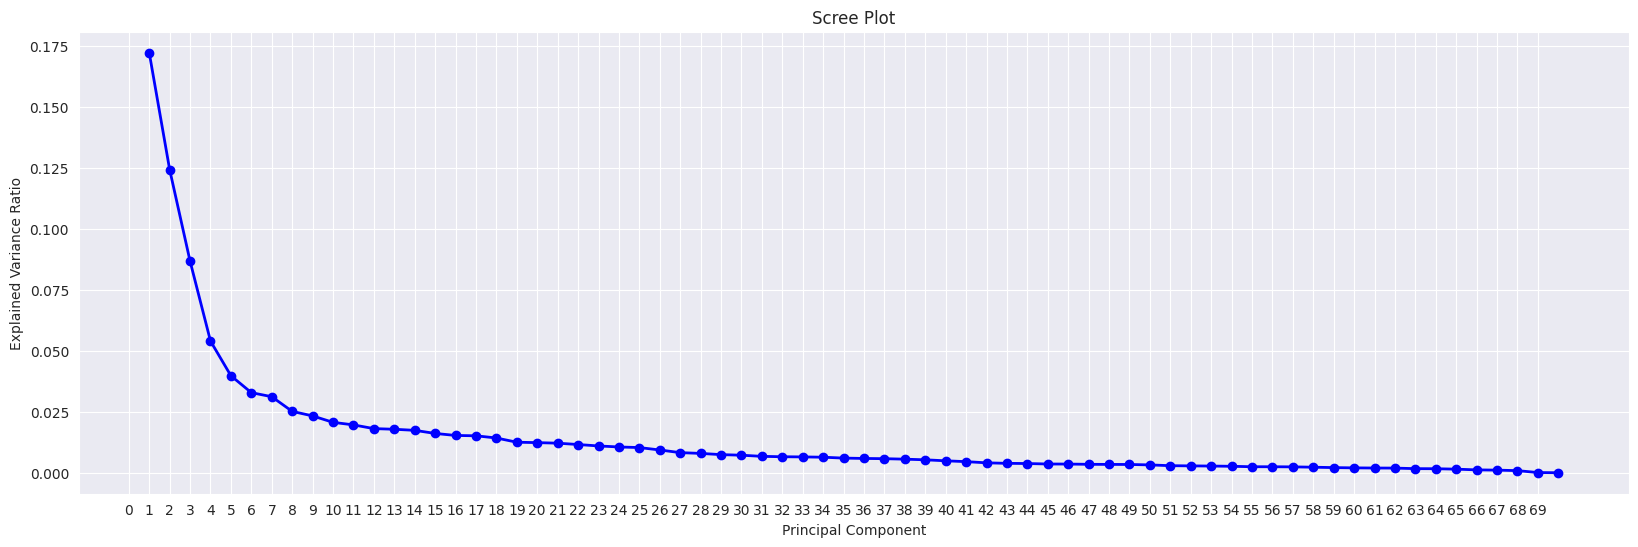

In [41]:
# Calculate the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

def scree_plot(explained_variance_ratio):
    # Create a Scree Plot
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, "o-", linewidth=2, color="b")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot")
    plt.xticks(np.arange(len(explained_variance_ratio)))
    plt.grid(True)

    # Show the plot
    plt.show()
scree_plot(explained_variance_ratio)

Principal Component: 6, cumulative variace: 51.0%
Principal Component: 28, cumulative variace: 85.1%
Principal Component: 36, cumulative variace: 90.4%


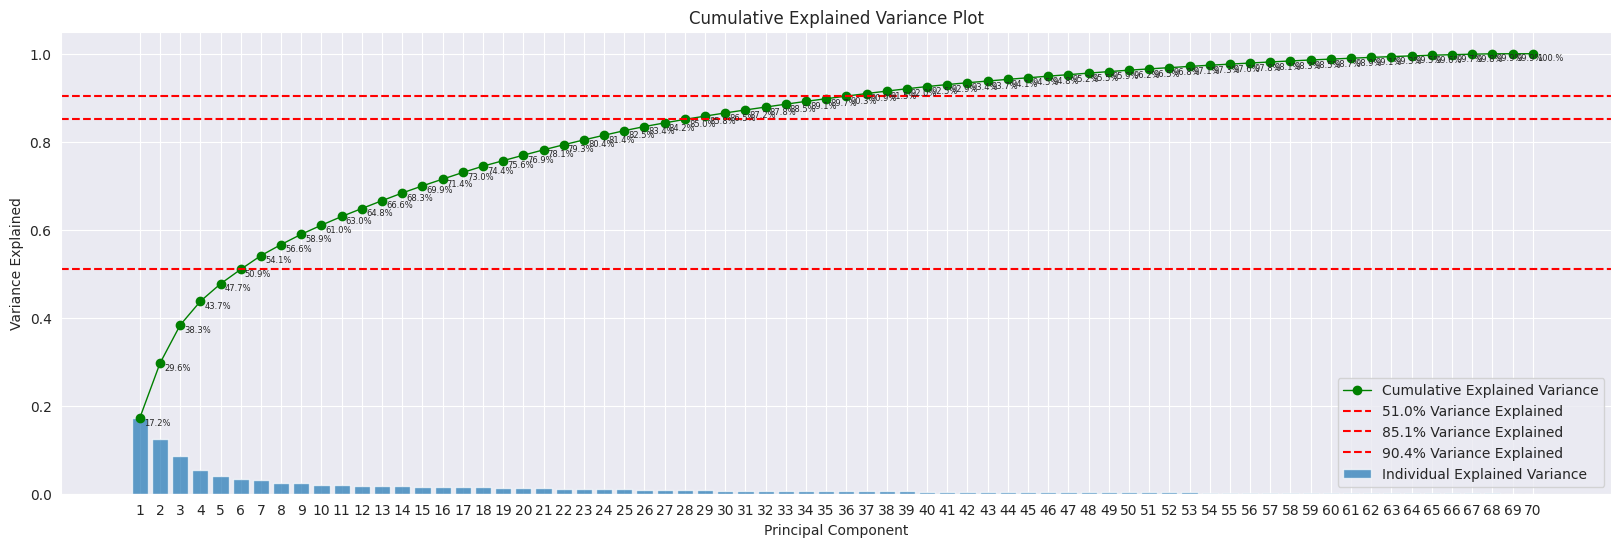

In [42]:
# Function to create a Variance Explained Plot (Cumulative Explained Variance Plot)
# modified source: from `helper_functions.py` of Course 4 Unsupervised Learning Lesson 4

def lines_plot(cumulative_variance, ind, percentage=None):
        # Find the index where the cumulative variance is greater than 90%
        plotting = []
        for i in percentage:
            try:
                threshold_index = np.where(cumulative_variance >= i)[0][0]
                get_PC = ind[threshold_index]
                print(f"Principal Component: {(get_PC)}, cumulative variace: {(cumulative_variance[threshold_index] * 100):.1f}%")
            except IndexError:
                pass    # Handle the case where: the number of principal component is reduced that leads to cumulative variance is not greater than 90%
            plotting.append([get_PC, cumulative_variance[threshold_index]])
        return plotting

def cumulative_variance_plot(pca):
    """
    Creates a cumulative explained variance plot.

    INPUT:
        pca - the result of PCA from scikit-learn

    OUTPUT:
        None
    """
    # Get explained variance ratio from PCA
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Define the x-axis indices for each principal component
    num_components = len(explained_variance_ratio)
    ind = np.arange(1,num_components + 1)


    # Create the plot
    plt.figure(figsize=(20, 6))
    plt.bar(ind, explained_variance_ratio, alpha=0.7, label="Individual Explained Variance")
    plt.plot(ind, cumulative_variance, "o-", linewidth=1, color="g", label="Cumulative Explained Variance")
    for i in range(num_components):
        plt.annotate(r"%s%%" % ((str(cumulative_variance[i]*100)[:4])), (ind[i]+0.2, cumulative_variance[i]), va="top", ha="left", fontsize=6)

    # Set labels, title, and legend
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    plt.title("Cumulative Explained Variance Plot")

    # Mark 50%, 85%, and 90% thresholds
    try:  # Handle the case after reducing the number of principal component
        plotting = lines_plot(cumulative_variance, ind, percentage=[0.5, 0.85, 0.90])
        for i in range(len(plotting)):
            plt.axhline(y=plotting[i][1], color="r", linestyle="--", label=f"{(plotting[i][1]*100):.1f}% Variance Explained")
    except UnboundLocalError:
        pass

    plt.xticks(ind)
    plt.grid(True)
    plt.legend()
    plt.show()

cumulative_variance_plot(pca)

In [43]:
# Scree plot shows the elbow of the data at 6 principal components and the cumulative variance plot shows that 36 components explain 90% of the variance in the data
# re-fit the PCA instance
pc_val = 28
pca = PCA(n_components=pc_val)
# Fit and transform the data.
pca_general_population = pca.fit_transform(df_std)

# explained variance ratio
print(f"PC: {pc_val}, Explained Variance Ratio: {pca.explained_variance_ratio_.sum()*100:.1f}%")

PC: 28, Explained Variance Ratio: 85.1%


Principal Component: 6, cumulative variace: 51.0%
Principal Component: 28, cumulative variace: 85.1%


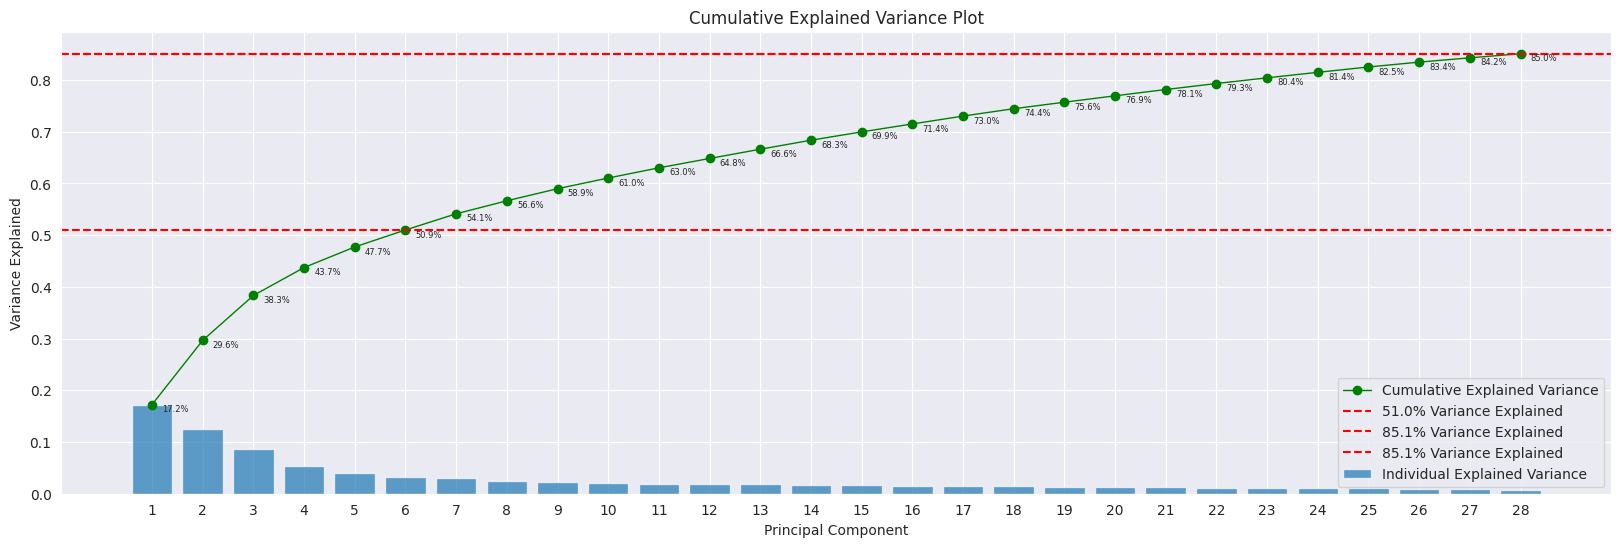

In [44]:
# Plot the cumulative variance
cumulative_variance_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Based on the Scree Plot and due to simplification of the process I choose to retain 6 principal components, because they explain 51% of the cumulative variance in the data.
To have a better overview of the data: the cumulative variance plot shows that 35 components explain 90% of the variance in the data.
The ideal approach would be to start with 6 principal components, perform clustering and access the results and gradually increase the number; 6, 10, 20, 35 and compare the clustering results.
I decided to use 28 principal components with cumulative variance of 85.1% to keep it simple and have appropriate variance.
Alternatively I could have used 35 principal components with cumulative variance of 90% to keep it complex.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [45]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pc_panda(df_std, pca, n_top_features=1, PC=0):
    """
    Create a DataFrame of features and their absolute weights
    df_std - the standardized dataframe with original feature names
    pca - the fitted PCA object from scikit-learn
    n_top_features - number of top features with the highest absolute variance to plot (default is 5)
    PC - Principal Component start with 0 is equal to PC1
    """
    feature_names = df_std.columns
    component_weights = pca.components_[PC]  # PC (n_top_features + 1)
    component_df = pd.DataFrame({
                "Feature": feature_names,
                "Weight": component_weights,
                "AbsWeight": np.abs(component_weights)
    })
    # Sort by absolute weight in descending order and select the top features
    top_features_df = component_df.sort_values(by="AbsWeight", ascending=False).head(n_top_features)
    top_features_df["PC"] = f"PC{PC + 1}"
    return top_features_df


# Print the top five features of the first principal component
pc_panda(df_std, pca, n_top_features=5, PC=0)

,Feature,Weight,AbsWeight,PC
52,MOBI_REGIO,0.236347,0.236347,PC1
58,PLZ8_ANTG3,-0.223169,0.223169,PC1
56,PLZ8_ANTG1,0.222675,0.222675,PC1
41,KBA05_ANTG1,0.218277,0.218277,PC1
59,PLZ8_ANTG4,-0.218245,0.218245,PC1


In [46]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Create a DataFrame of features and their absolute weights

# Print the top five features of the second principal component
pc_panda(df_std, pca, 5, 1)


,Feature,Weight,AbsWeight,PC
66,PRAEGENDE_JUGENDJAHRE_DECADE,0.266370,0.266370,PC2
16,SEMIO_REL,0.265860,0.265860,PC2
0,ALTERSKATEGORIE_GROB,-0.260706,0.260706,PC2
3,FINANZ_SPARER,0.256083,0.256083,PC2
4,FINANZ_VORSORGER,-0.248598,0.248598,PC2


In [47]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Print the top five features of the third principal component
pc_panda(df_std, pca, 5, 2)

,Feature,Weight,AbsWeight,PC
1,ANREDE_KZ,0.369706,0.369706,PC3
18,SEMIO_VERT,-0.347684,0.347684,PC3
25,SEMIO_KAEM,0.338805,0.338805,PC3
24,SEMIO_DOM,0.313058,0.313058,PC3
23,SEMIO_KRIT,0.275419,0.275419,PC3


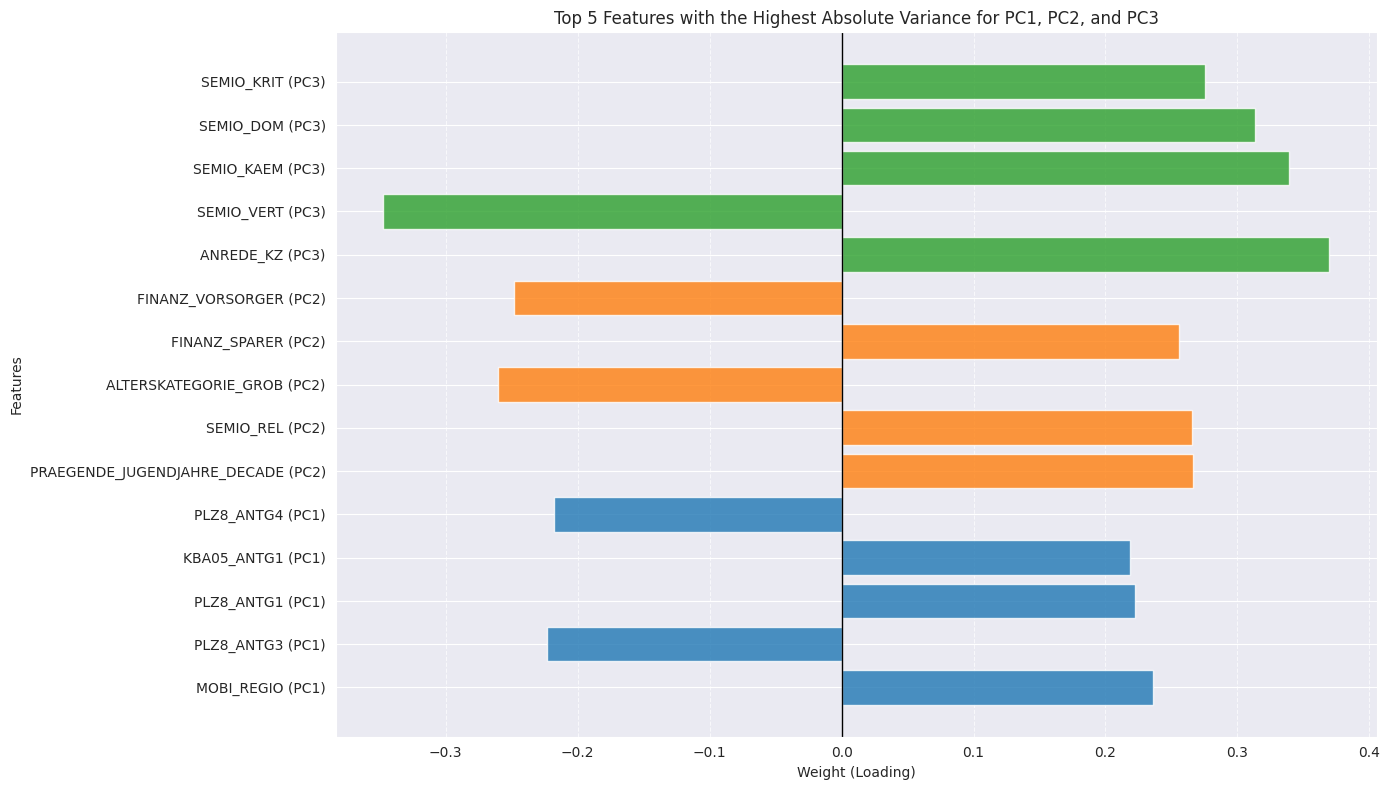

In [48]:
# Plot the features with the highest absolute variance for each component
def plot_top_features_per_component(pca, df_std, n_top_features=5, PC=0):
    """
    Plots the features with the highest absolute variance for the first three principal components.

    INPUT:
        pca - the fitted PCA object from scikit-learn
        df_std - the standardized dataframe with original feature names
        n_top_features - number of top features with the highest absolute variance to plot (default is 5)

    OUTPUT:
        None
    """
    # Extract the feature names
    feature_names = df_std.columns

    # Create a list to store DataFrames for each principal component
    top_features_list = []

    # Loop through the first three principal components (PC1, PC2, PC3)
    for i in range(PC+1):
        top_features_df = pc_panda(df_std, pca, n_top_features, i)

        # Append to the list
        top_features_list.append(top_features_df)

    # Concatenate the DataFrames for each PC
    top_features_combined = pd.concat(top_features_list)

    # Plot the features with the highest absolute variance for each component
    plt.figure(figsize=(14, 8))
    for i, pc in enumerate(["PC1", "PC2", "PC3"]):
        pc_df = top_features_combined[top_features_combined["PC"] == pc]
        plt.barh(pc_df["Feature"] + f" ({pc})", pc_df["Weight"], alpha=0.8, label=f"{pc}")

    plt.xlabel("Weight (Loading)")
    plt.ylabel("Features")
    plt.title(f"Top {n_top_features} Features with the Highest Absolute Variance for PC1, PC2, and PC3")
    plt.axvline(0, color="black", lw=1)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the first 5 features with the highest absolute variance of the first three principal components
plot_top_features_per_component(pca, df_std, 5, 2)


### Discussion 2.3: Interpret Principal Components

Using top 5 features in the first three principal components (PC):

**Reminder**: The features in PC1, PC2, PC3:
 - Principal components are designed to be orthogonal to each other, which means they capture different directions in the data space that do not share any overlap.
 - Orthogonality also implies that the variance captured by each component is independent of the others. **Therefore, if a feature has a significant weight loading (either positive or negative) in one PC component, it is independent of its contribution to another PC component**.

--> It means that features from same principal component can be compared with each other, but not with features from other principal components.

--> Features with opposite signs have a negative correlation, indicating that an increase in one feature corresponds to a decrease in another.

--> Features with large weights of the same sign are positively correlated in the corresponding component, indicating that they tend to increase or decrease together.

PC1: **residential characteristics and urbanization**
- ++ MOBI_REGIO: Movement patterns
- -- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
- ++ PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- ++ KBA05_ANTG1: Number of 1-2 family houses in the microcell
- -- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region

Similar positive weight features like: Movement patterns, Number of 1-2 family houses in the PLZ8 region, Number of 1-2 family houses in the microcell are correlated with each other and tend to change together.
Same for the negative sign weight features like: Number of 6-10 family houses in the PLZ8 region, Number of 10+ family houses in the PLZ8 region.

PC2: **socio-cultural and economic characteristics**
- ++ PRAEGENDE_JUGENDJAHRE_DECADE: Influential youth decade
- ++ SEMIO_REL: Religious personality typology
- -- ALTERSKATEGORIE_GROB: Estimated age category
- ++ FINANZ_SPARER: Financial typology (investors)
- -- FINANZ_VORSORGER: Financial typology (savers)

Similar positive weight features like: Influential youth decade, Religious personality typology, Financial typology (investors) are correlated with each other and tend to change together.
Same for the negative sign weight features like: Estimated age category, Financial typology (savers).

PC3: **personality typologies and gender-related behavior patterns**
- ++ ANREDE_KZ: Gender
- -- SEMIO_VERT: Dreamful personality typology
- ++ SEMIO_KAEM: Combative attitude
- ++ SEMIO_DOM: Dominant-minded personality typology
- ++ SEMIO_KRIT: Critical-minded personality typology

Similar positive weight features like: Gender, Dominant-minded personality typology, Critical-minded personality typology are correlated with each other and tend to change together.
Due to opposite sign of feature weights: if Dreamful personality typology is ingreacing, it means that Combative attitude decreases.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Apply k-means clustering for different cluster counts
def kmeans_clustering_analysis(pca_general_population, max_k=10):
    """
    Applies k-means clustering over different cluster counts and computes average within-cluster distances.

    INPUT:
        pca_general_population - PCA-transformed data (numpy array or DataFrame)
        max_k - Maximum number of clusters to consider for elbow method

    OUTPUT:
        None (plots the average within-cluster distance for different k values)
    """
    avg_within_cluster_distances = []
    k_values = range(1, max_k + 1)

    # Iterate over cluster counts
    for k in k_values:
        # Initialize and fit k-means model
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_general_population)

        # Calculate average within-cluster distance (negative score returned by KMeans, make it positive)
        score = -kmeans.score(pca_general_population)
        avg_distance = score / len(pca_general_population)
        avg_within_cluster_distances.append(avg_distance)

    # Step 2: Plot average within-cluster distances to find the "elbow point"
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, avg_within_cluster_distances, marker="o")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Average Within-Cluster Distance")
    plt.title("Elbow Method to Determine Optimal Number of Clusters")
    plt.grid(True)
    plt.show()


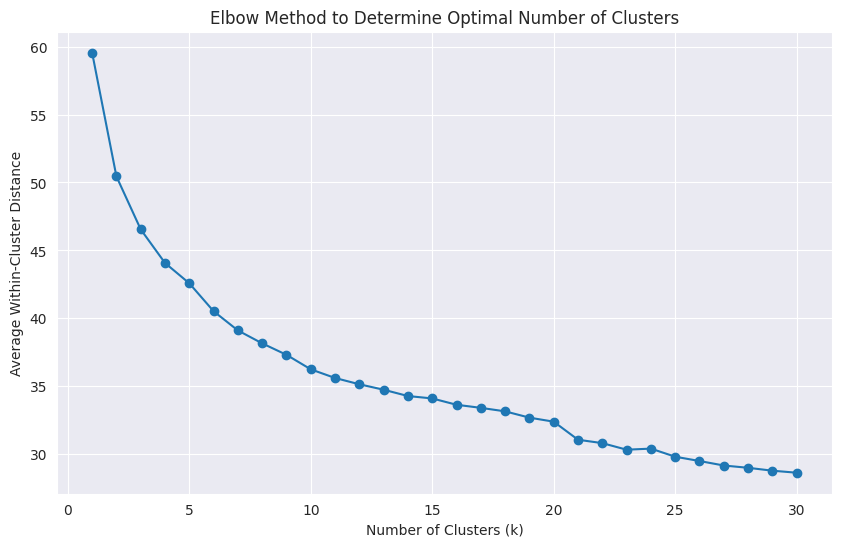

In [50]:
# Call function to perform the elbow analysis
kmeans_clustering_analysis(pca_general_population, max_k=30)

In [51]:
# Step 3: Re-fit the K-Means model with the selected number of clusters
# After observing the plot, k=21 is the optimal number of clusters.
optimal_k = 21
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_model_population = kmeans.fit(pca_general_population)
# Obtain cluster predictions
cluster_labels = kmeans.fit_predict(pca_general_population)   # label each data point by cluster

# Reporting the results
print(f"Cluster predictions by K-Means for {optimal_k} clusters.\n"
      f"Check the unique cluster labels (np.unique(cluster_labels):\n"
      f"{np.unique(cluster_labels)}")


Cluster predictions by K-Means for 21 clusters.
Check the unique cluster labels (np.unique(cluster_labels):
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


### Discussion 3.1: Apply Clustering to General Population

After running k-means clustering over different values of `k` and observing the elbow plot, it appears that the "elbow point" is at `k = 21`. This is where the decrease in within-cluster distance starts to slow down. These clusters will help me to understand different segments of the population based on the principal components of the demographics data. Each cluster represents a group of individuals with similar characteristics in the reduced feature space created by PCA. Further analysis of these clusters may reveal actionable insights into customer behavior, demographics, or other related attributes.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")
# Load in the feature summary file.
azdias_feat = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [53]:
import pandas as pd
import numpy as np
import ast

def clean_data(df, df_feature_summary):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.

    INPUT: Demographics DataFrame and Feature Summary DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame and updated Feature Summary DataFrame
    """

    # Handle missing values
    df = replace_missing_values(df, df_feature_summary)

    # Remove columns and rows with excess missing values
    df, df_feature_summary = remove_missing_columns_and_rows(df, df_feature_summary, col_threshold=15, row_threshold=10)

    # Categorical feature encoding
    df, df_feature_summary = encode_categorical_features(df, df_feature_summary)

    # Engineer mixed-type features
    df = engineer_mixed_features(df)

    # Drop mixed-type features from feature summary
    df_feature_summary = drop_mixed_type_features(df_feature_summary)

    return df, df_feature_summary


def replace_missing_values(azdias_subset, azdias_feature_summary):
        # Ensure alignment of columns between the two dataframes
        matching_columns = azdias_subset.columns.intersection(azdias_feature_summary["attribute"])
        for col in matching_columns:
            # Extract the missing_or_unknown values for the column
            missing_values = azdias_feature_summary.loc[azdias_feature_summary["attribute"] == col, "missing_or_unknown"].iloc[0]

            try:
                # Safely parse the missing values as a Python list
                missing_values_list = ast.literal_eval(missing_values)
            except (ValueError, SyntaxError):
                # Fallback: Split by commas if the string isn't a valid list
                missing_values_list = missing_values.split(",")

            # Ensure all values are stripped of whitespace and converted to strings
            missing_values_list = [str(value).strip() for value in missing_values_list]

            # Replace these values with NaN in the azdias_subset
            azdias_subset[col] = azdias_subset[col].astype(str).replace(missing_values_list, np.nan)
            azdias_subset.replace("nan", np.nan, inplace=True)
            return  azdias_subset


def remove_missing_columns_and_rows(df, df_feature_summary, row_threshold=10, col_threshold=15):
    """
    # HARDCODED: to be able to drop the same columns as from Demographics DataFrame (clustering is sensitive to missing values and scaling)
    - drop_col_list = ["AGER_TYP", "KK_KUNDENTYP"]
    - row_threshold=10

    Remove columns and rows exceeding the specified missing value thresholds.
    """
    # Remove columns with missing values above the threshold
    missing_percent = (df.isna().sum() / df.shape[0]) * 100
    drop_col_list = ["AGER_TYP", "KK_KUNDENTYP", "CJT_GESAMTTYP", "FINANZTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "NATIONALITAET_KZ", "SHOPPER_TYP", "TITEL_KZ", "VERS_TYP", "ZABEOTYP", "GEBAEUDETYP", "CAMEO_DEUG_2015", "CAMEO_DEU_2015"]    # HARDCODED: to be able to drop the same columns as from Demographics DataFrame (clustering is sensitive to missing values and scaling)
    #drop_col_list = missing_percent[missing_percent > col_threshold].index.tolist()
    try:
        df = df.drop(columns=drop_col_list)
    except KeyError as e:
        print(f"Columns {drop_col_list} not found in dataset or may have already been dropped.")
    df_feature_summary = df_feature_summary[df_feature_summary["attribute"].isin(df.columns.tolist())]

    # Remove rows with missing values above the threshold
    row_missing = df.isna().sum(axis=1)
    df = df[(row_missing <= 10)]    # HARDCODED: to be able to drop the same columns as from Demographics DataFrame (clustering is sensitive to missing values and scaling)
    #df = df[(row_missing <= row_threshold)]
    return df, df_feature_summary


def encode_categorical_features(df, df_feature_summary):
    """
    Encode categorical features, classify as binary, multi-level, or non-numeric.
    """
    categorical_columns = df_feature_summary[df_feature_summary["type"] == "categorical"]["attribute"]
    features = classify_categorical_features(df, categorical_columns)

    # Re-encode specific columns (e.g. "OST_WEST_KZ")
    pd.set_option("future.no_silent_downcasting", True) # Silent downcasting warnings
    if "OST_WEST_KZ" in df.columns:
        df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1}).astype(int)

    # Drop multi-level categorical columns from dataframe and feature summary
    drop_cols = [col[0] for col in features["multi"]]   # TODO: hardcode to obtain same dropping columns as from Demographics DataFrame
    df = df.drop(columns=drop_cols)
    df_feature_summary = df_feature_summary[~df_feature_summary["attribute"].isin(drop_cols)]

    return df, df_feature_summary


def classify_categorical_features(df, categorical_columns):
    """
    Classify categorical features as binary, multi-valued, or non-numeric.
    """
    features = {"binary": [], "multi": [], "non_numeric": []}
    for col in categorical_columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            features["non_numeric"].append([col, df[col].nunique()])
        else:
            unique_count = df[col].nunique()
            if unique_count <= 2:
                features["binary"].append([col, unique_count])
            else:
                features["multi"].append([col, unique_count])
    return features


def engineer_mixed_features(df):
    """
    Engineer new features from mixed-type columns such as "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015".
    """
    # Engineer "PRAEGENDE_JUGENDJAHRE"
    decade_dict = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
    movement_dict = {0: np.nan, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1}
    if "PRAEGENDE_JUGENDJAHRE" in df.columns:
        df["PRAEGENDE_JUGENDJAHRE"] = df["PRAEGENDE_JUGENDJAHRE"].astype(float)
        df["PRAEGENDE_JUGENDJAHRE_DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].map(decade_dict)
        df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].map(movement_dict)
        df.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)

    # Engineer "CAMEO_INTL_2015"
    if "CAMEO_INTL_2015" in df.columns:
        df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].replace("XX", np.nan).astype(float)
        df["CAMEO_INTL_2015_WEALTH_LEVEL"] = df["CAMEO_INTL_2015"] // 10
        df["CAMEO_INTL_2015_HOUSEHOLD_TYPE"] = df["CAMEO_INTL_2015"] % 10
        df.drop(columns=["CAMEO_INTL_2015"], inplace=True)

    return df


def drop_mixed_type_features(df_feature_summary):
    """
    Drop mixed-type features from the feature summary DataFrame.
    """
    mixed_type_features = df_feature_summary[df_feature_summary["type"] == "mixed"]["attribute"].tolist()
    df_feature_summary = df_feature_summary[~df_feature_summary["attribute"].isin(mixed_type_features)]
    return df_feature_summary


In [54]:
# Applying all engineering steps to the customer data
df_customers, customers_feat_summary = clean_data(customers, azdias_feat)

In [55]:
# Check if there are any non-numeric columns
df_customers.select_dtypes(exclude=[np.number]).columns

Index([], dtype='object')

In [56]:
# Replacing all missing values with the mean value of the column
df_customers_imputed = impute_missing_values(df_customers)

In [57]:
# IMPORTANT: Apply already fitted sklearn StandardScaler() (=std_scaler) to the customer data
df_std_customers = pd.DataFrame(std_scaler.transform(df_customers_imputed), columns=df_customers_imputed.columns)

In [58]:
# Transform customer data & just for safety general population data
df_std_pca = pca.transform(df_std)  # Transform general population data
df_std_customers_pca = pca.transform(df_std_customers)  # Transform customer data

In [59]:
# Create DataFrames for the cluster labels
demograph_label = kmeans_model_population.predict(df_std_pca)
customer_label = kmeans_model_population.predict(df_std_customers_pca)

# Convert to DataFrame
demograph_df = pd.DataFrame({"demograph_label": demograph_label})
customer_df = pd.DataFrame({"customer_label": customer_label})

# Count frequency of points
demograph_df_freq = demograph_df["demograph_label"].value_counts().sort_index() / sum(demograph_df["demograph_label"].value_counts())
customer_df_freq = customer_df["customer_label"].value_counts().sort_index() / sum(customer_df["customer_label"].value_counts())

# Combine the two DataFrames
cluster_compare_demographic_customers = pd.DataFrame({
    "demographic_proportions": demograph_df_freq*100,
    "customers_proportions": customer_df_freq*100
})
cluster_compare_demographic_customers.index.name = "Cluster"
customer_df_freq.sum()

np.float64(1.0000000000000002)

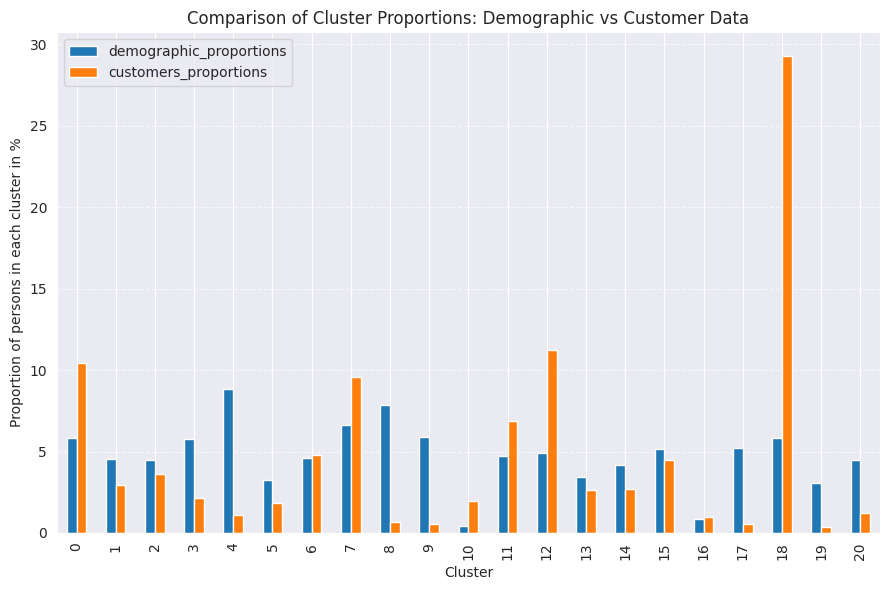

In [60]:
# Plot the comparison between demographic and customer proportions for each cluster
#cluster_compare_demographic_customers.index = cluster_compare_demographic_customers.index + 1

# Plot the comparison between demographic and customer proportions for each cluster
cluster_compare_demographic_customers.plot(
    y=["demographic_proportions", "customers_proportions"],
    kind="bar",
    figsize=(9, 6)
)

plt.ylabel("Proportion of persons in each cluster in %")
plt.xlabel("Cluster")
plt.title("Comparison of Cluster Proportions: Demographic vs Customer Data")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

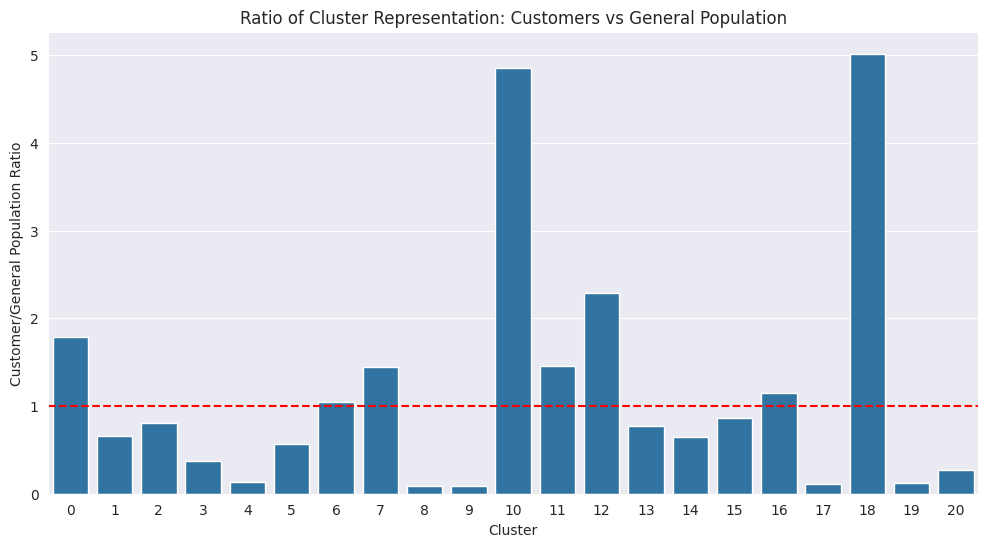

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming the following objects have been defined in previous steps:
# - df_std_pca (General population data, cleaned, and preprocessed with the same number of features as used for training KMeans)
# - kmeans (Trained KMeans model for clustering with 28 features)
# - std_scaler (StandardScaler fitted on general population data with 28 features)
# - df_std_customers (Standardized customer dataset with 28 features)

# Ensure the input datasets have the same number of features as used in training the KMeans model

# Apply KMeans clustering to general population and customer datasets
general_clusters = kmeans.predict(df_std_pca)
customer_clusters = kmeans.predict(df_std_customers_pca)

# Create dataframes to store the cluster assignments
df_general_clusters = pd.DataFrame({'cluster': general_clusters})
df_customer_clusters = pd.DataFrame({'cluster': customer_clusters})

# Calculate the proportion of data points in each cluster for the general population and customers
general_cluster_counts = df_general_clusters['cluster'].value_counts(normalize=True)
customer_cluster_counts = df_customer_clusters['cluster'].value_counts(normalize=True)

# Merge cluster proportions into a single dataframe to compare proportions
proportion_comparison = pd.concat([general_cluster_counts, customer_cluster_counts], axis=1, keys=['general_population', 'customers']).fillna(0)

# Visualize the ratio of cluster representation between customers and the general population
proportion_comparison['ratio'] = proportion_comparison['customers'] / proportion_comparison['general_population']

plt.figure(figsize=(12, 6))
sns.barplot(x=proportion_comparison.index, y='ratio', data=proportion_comparison)
plt.title('Ratio of Cluster Representation: Customers vs General Population')
plt.xlabel('Cluster')
plt.ylabel('Customer/General Population Ratio')
plt.xticks(rotation=0)
plt.axhline(1, color='red', linestyle='--')
plt.show()


In [62]:
def proportions_percent(clusters):
    proportions_percent = clusters.copy()
    return proportions_percent

def plot_proportions_percent(clusters_percent, x_label="Cluster", y_label="Proportion in %", title="Overrepresented Customer Cluster Proportions in comparison to Demographic Cluster"):
    # Plot the comparison between demographic and customer proportions for each cluster
    clusters_percent.plot(
        y=["demographic_proportions", "customers_proportions"],
        kind="bar",
        figsize=(9, 6)
    )
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

proportions_percent = proportions_percent(cluster_compare_demographic_customers)

# Over-Under-represented clusters
underrepresented_clusters = proportions_percent[proportions_percent["demographic_proportions"] > proportions_percent["customers_proportions"]]
overrepresented_clusters = proportions_percent[proportions_percent["demographic_proportions"] < proportions_percent["customers_proportions"]]

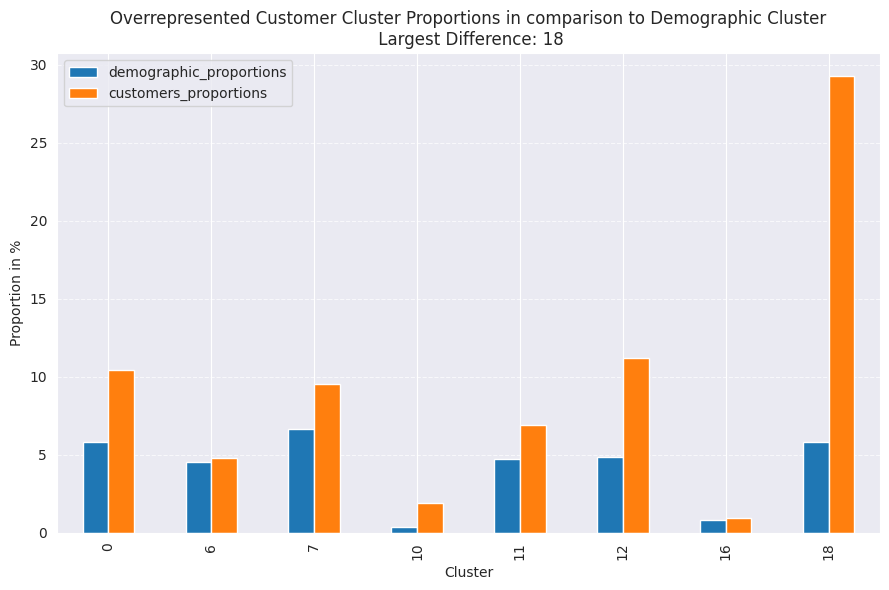

In [63]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
largest_overrepresented_cluster = overrepresented_clusters[max(abs(overrepresented_clusters["demographic_proportions"] - overrepresented_clusters["customers_proportions"])) == abs(overrepresented_clusters["demographic_proportions"] - overrepresented_clusters["customers_proportions"])]

plot_proportions_percent(overrepresented_clusters, title="Overrepresented Customer Cluster Proportions in comparison to Demographic Cluster\n Largest Difference: " + str(largest_overrepresented_cluster.index[0]))


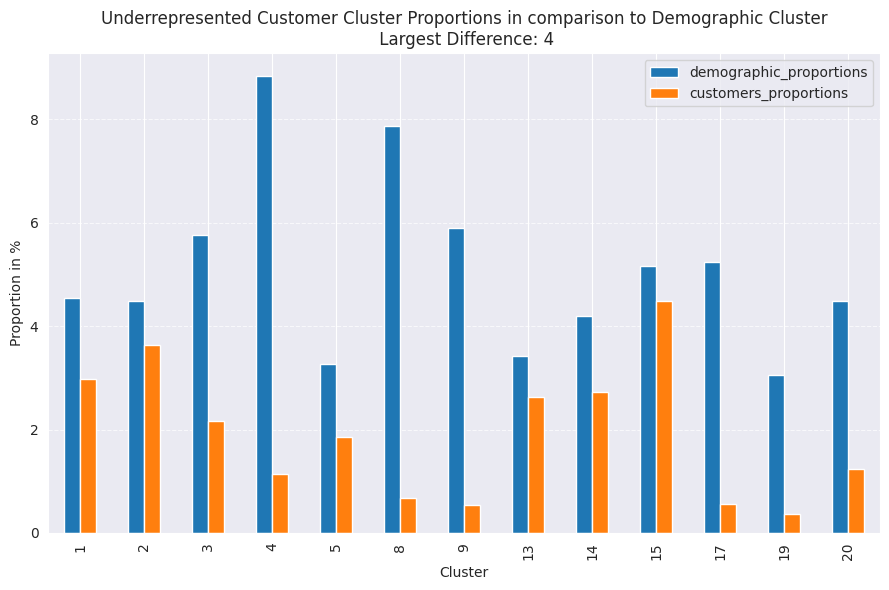

In [64]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
largest_underrepresented_cluster = underrepresented_clusters[max(abs(underrepresented_clusters["demographic_proportions"] - underrepresented_clusters["customers_proportions"])) == abs(underrepresented_clusters["demographic_proportions"] - underrepresented_clusters["customers_proportions"])]
plot_proportions_percent(underrepresented_clusters, title="Underrepresented Customer Cluster Proportions in comparison to Demographic Cluster\n Largest Difference: " + str(largest_underrepresented_cluster.index[0]))



In [65]:
# Credits to ChatGPT-4o for the following code

# Step 1: Separate Demographic and Customer Data by Cluster
# Get the cluster labels for demographic and customer data
demographic_labels = demograph_label
customer_labels = customer_label

# Convert demographic and customer data back to the original space
# Transform back from the PCA space to standardized space and then to original feature space
def get_cluster_centroids_pca(data_pca, labels, num_clusters):
    cluster_centroids_pca = []

    for cluster in range(num_clusters):
        # Get data points belonging to the cluster
        cluster_points = data_pca[labels == cluster]
        # Calculate cluster centroid in PCA space
        centroid_pca = cluster_points.mean(axis=0)
        cluster_centroids_pca.append(centroid_pca)

    return np.array(cluster_centroids_pca)

# Number of clusters
num_clusters = kmeans.n_clusters

# Get centroids for demographic and customer data in PCA space
demographic_centroids_pca = get_cluster_centroids_pca(df_std_pca, demographic_labels, num_clusters)
customer_centroids_pca = get_cluster_centroids_pca(df_std_customers_pca, customer_labels, num_clusters)

# Step 2: Transform Centroids to Original Feature Space
# Convert centroids back to standardized space
demographic_centroids_standardized = pca.inverse_transform(demographic_centroids_pca)
customer_centroids_standardized = pca.inverse_transform(customer_centroids_pca)

# Convert centroids to original feature space
demographic_centroids_original = std_scaler.inverse_transform(demographic_centroids_standardized)
customer_centroids_original = std_scaler.inverse_transform(customer_centroids_standardized)

# Create DataFrames for better readability
demographic_centroids_df = pd.DataFrame(demographic_centroids_original, columns=df_std.columns)
customer_centroids_df = pd.DataFrame(customer_centroids_original, columns=df_std_customers.columns)

# Step 3: Compare the Features in the Same Principal Component
# Compare the cluster centroids between demographic and customer data
# Calculate the differences between corresponding clusters
centroid_diff_df = (demographic_centroids_df - customer_centroids_df)/(demographic_centroids_df + customer_centroids_df)

print("Demographic Centroids (Original Feature Space):")
demographic_centroids_df

Demographic Centroids (Original Feature Space):


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH_LEVEL,CAMEO_INTL_2015_HOUSEHOLD_TYPE
0,3.419194,1.948236,4.158156,1.535928,4.297652,1.974417,2.139694,2.471215,1321.858480,0.967432,2.053113,23.977582,6.953336,3.659443,2.873496,2.008705,2.108896,2.433254,3.100125,5.273603,6.266555,1.993775,3.590340,5.675956,6.151736,5.869733,3.018147,2.876991,0.000014,11.544404,2.211479,0.000009,2.448800,3.915059,8.510513,1.712430,0.005601,3.365543,1992.879465,0.088418,2.829646,2.773544,1.076289,0.080433,0.004052,0.681284,4.102639,3.833262,4.210828,4.432631,3.991146,2.068246,4.173070,3.153509,3.355710,700.576460,2.773248,2.573790,1.231934,0.425698,1.277414,3.765082,3.914754,3.100880,5.733077,3.060707,65.312206,0.968994,2.020279,3.702832
1,3.468568,1.973409,2.368556,2.198692,3.974742,2.386734,1.912776,4.332677,1143.941251,0.073379,2.017535,11.706368,3.664036,4.200418,3.127321,2.271736,2.216790,2.439366,2.597543,5.045356,6.437139,2.053800,3.495421,6.050576,6.009814,6.300065,3.097360,2.481132,0.000023,9.522662,1.462842,-0.000544,5.502302,4.521995,8.075036,9.251855,0.038585,1.871969,1992.475269,0.359458,3.419521,0.261330,1.368264,1.868259,0.254715,1.997631,2.298332,2.760836,5.574927,2.772617,3.381138,2.894334,1.822709,1.939628,4.985393,430.893329,1.103974,3.618535,2.799745,1.466088,3.552693,3.600003,2.302010,3.809168,7.366808,3.886414,66.334759,0.083743,4.465734,2.192440
2,3.196406,1.907748,3.760096,2.531114,3.395358,3.515802,2.682388,1.966995,1660.972227,0.244556,2.149400,30.296397,9.153625,2.862977,2.680037,2.353643,2.618047,2.636265,3.186064,4.381448,6.023701,2.468220,3.843286,5.431408,5.446787,5.386952,3.433883,3.157756,0.000013,15.545081,2.909439,-0.000495,3.256906,2.141793,8.458465,1.336151,0.006894,4.276634,1994.767510,0.189470,5.860703,2.626546,0.918405,0.092023,0.030808,0.695165,4.215235,5.445731,2.121642,6.101745,4.089177,2.432033,4.271070,3.980351,3.613062,669.875035,3.021651,2.080997,0.678736,0.140947,0.968092,3.205221,3.808729,2.394334,2.826755,2.094438,75.754450,0.245814,2.162606,3.209432
3,2.964643,1.068556,3.209535,2.793931,3.294045,2.319168,2.561494,2.714596,1222.903156,0.096799,2.818421,11.308300,3.498882,4.078100,5.280928,5.237419,3.978723,4.331438,5.731326,4.030052,3.914881,5.267326,3.014126,3.933767,3.851804,3.134041,3.786745,3.415548,0.000010,11.138966,1.323942,-0.000288,5.244848,4.036469,7.649271,7.283358,0.029490,2.347520,1992.675411,0.143121,3.475772,0.765343,2.055042,1.180806,0.168965,1.376672,2.757714,3.744857,4.731894,3.931716,3.597784,2.811883,2.331689,2.271126,4.719867,597.521533,1.811802,3.411743,2.101202,0.889077,2.336686,3.777110,3.226525,3.531234,6.238862,3.697686,75.176176,0.093201,4.086521,2.244456
4,1.574846,1.992735,2.328185,3.993416,2.210691,4.425014,3.864585,2.825352,1347.152151,0.189290,2.115872,16.999886,5.242859,2.371657,3.004848,3.796149,5.364606,5.207395,2.468565,2.942772,4.197726,4.175473,6.366046,5.494188,6.103154,5.681733,6.313784,5.958011,-0.000011,13.018853,1.962252,-0.000047,4.028068,3.293367,7.572180,3.236423,0.006457,3.680849,1993.483077,0.161299,4.573950,2.194927,1.383698,0.256590,0.070505,0.751146,3.858669,4.939599,3.018593,5.431090,4.020997,2.

In [66]:
print("\nDifferences Between Demographic and Customer Centroids:")
centroid_diff_df.head()


Differences Between Demographic and Customer Centroids:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH_LEVEL,CAMEO_INTL_2015_HOUSEHOLD_TYPE
0,-0.027143,0.001917,-0.018916,0.168592,-0.054180,0.124415,0.073923,-0.049677,-0.014054,-0.005401,0.039262,-0.040423,-0.041117,-0.002225,-0.008356,0.025021,0.062955,0.024606,-0.017050,-0.046687,-0.014071,0.054043,0.033802,0.010978,0.013374,0.007824,0.054519,0.044340,-0.278051,-0.003366,-0.038417,-0.953023,0.015441,-0.049727,-0.015963,-0.004641,0.320017,0.017582,0.000056,0.410358,0.012214,0.001558,-0.010806,0.001892,0.903903,0.060096,0.001194,-0.004332,-0.004553,-0.006766,0.004440,0.020010,0.001490,0.005817,0.007500,0.011038,0.011316,-0.019876,-0.028859,-0.045525,-0.029493,0.005099,0.010764,0.013998,0.000740,-0.001931,0.036395,-0.004893,-0.001558,-0.005889
1,-0.021856,0.001379,-0.057310,0.155605,-0.074080,0.162214,0.082883,-0.021962,-0.076431,-0.386402,0.053808,-0.080909,-0.071387,0.003079,-0.007135,0.020258,0.047946,0.012171,-0.026563,-0.051266,-0.008902,0.051579,0.023136,0.011130,0.013968,0.006598,0.044929,0.031413,-0.584901,-0.050314,-0.054075,1.354858,0.031358,-0.059978,-0.018812,0.013285,-0.075779,0.060151,0.000024,0.182937,0.034477,-0.128226,-0.006092,0.010435,0.025196,0.002808,-0.004795,0.034227,-0.015397,0.010364,0.018249,0.033422,-0.012673,-0.024385,0.015824,0.003345,-0.001298,-0.013609,-0.005841,-0.003572,-0.002984,0.000309,0.002416,0.016880,-0.009889,-0.005730,0.042490,-0.347998,0.024089,-0.055488
2,-0.031186,0.002494,-0.041668,0.131106,-0.086232,0.084780,0.086892,-0.035355,-0.026249,-0.054486,0.039405,-0.066950,-0.066224,-0.007936,-0.002933,0.027674,0.047426,0.025377,-0.015218,-0.053687,-0.016205,0.033767,0.027137,0.015828,0.010938,0.007952,0.042046,0.041678,-0.615808,-0.019876,-0.058459,0.324841,0.024872,-0.031109,-0.022097,0.038668,0.180867,0.021899,0.000148,0.350709,0.003717,-0.018518,0.000322,0.262744,0.602358,0.053136,-0.005773,0.000538,0.000786,-0.009837,0.011908,0.001239,-0.008966,-0.009967,-0.009576,-0.026440,0.000229,-0.018273,-0.026120,-0.084093,-0.013966,-0.011790,-0.005537,0.054658,0.015426,0.042848,0.037303,-0.049776,0.013711,-0.007181
3,-0.011140,0.004656,-0.052450,0.073012,-0.051792,0.112411,0.030748,0.025285,-0.101456,-0.308044,0.031675,-0.201105,-0.196283,0.022266,0.002103,-0.000329,0.003635,-0.019388,-0.013977,-0.042969,-0.003854,0.003207,-0.004152,0.025003,0.003953,0.004019,0.010881,-0.005086,-0.805050,-0.094632,-0.155357,-8.312071,0.047109,0.019256,-0.019985,0.037784,-0.171172,0.045100,-0.000026,0.415410,0.055366,-0.128120,-0.011288,0.092424,0.089510,0.055844,-0.028850,0.041904,-0.023630,0.018626,0.012213,0.034044,-0.041803,-0.097792,0.020998,-0.007579,0.010779,-0.017135,-0.016210,-0.023562,-0.017396,-0.006218,0.002090,0.017635,-0.021128,0.003889,0.016638,-0.305287,0.031296,-0.035029
4,-0.030521,0.006636,-0.134545,0.097667,-0.115143,0.079868,0.072829,0.085135,-0.067602,-0.193812,0.025996,-0.146337,-0.139816,-0.079295,0.013412,0.001381,0.001730,-0.021129,-0.031793,-0.021144,-0.008964,-0.009557,-0.006204,0.006555,-0.006217,-0.001873,0.002146,0.000244,-2.787297,-0.057455,-0.096440,-0.288053,0.065475,0.056373,-0.032509,0.173910,-0.433879,0.016444,-0.000106,0.208121,

In [67]:
def cluster_centroids_original(cluster_number, df_std, kmeans, pca, std_scaler):
    cluster_center_reshaped = kmeans.cluster_centers_[cluster_number].reshape(1, -1)
    pca_inverse = pca.inverse_transform(cluster_center_reshaped)
    std_inverse = std_scaler.inverse_transform(pca_inverse)
    result_population_original = pd.Series(data=std_inverse.flatten(), index=df_std.columns)
    return result_population_original


#cluster_4 = pd.DataFrame(cluster_centroids_original(4, df_std, kmeans, pca, std_scaler), columns=df_std.columns)
a = pd.concat([cluster_centroids_original(4, df_std, kmeans, pca, std_scaler), cluster_centroids_original(18, df_std_customers, kmeans, pca, std_scaler)], axis=1).rename(columns={0: "cluster_4", 1: "cluster_18"})
a.head(n=100)

,cluster_4,cluster_18
ALTERSKATEGORIE_GROB,1.574874,3.408598
ANREDE_KZ,1.992750,1.061585
FINANZ_MINIMALIST,2.328072,4.953270
FINANZ_SPARER,3.993344,1.356439
FINANZ_VORSORGER,2.210782,4.431011
FINANZ_ANLEGER,4.424832,1.250572
FINANZ_UNAUFFAELLIGER,3.864487,1.941742
FINANZ_HAUSBAUER,2.825574,2.004049
GEBURTSJAHR,1347.196004,1195.562075
GREEN_AVANTGARDE,0.189272,0.970100


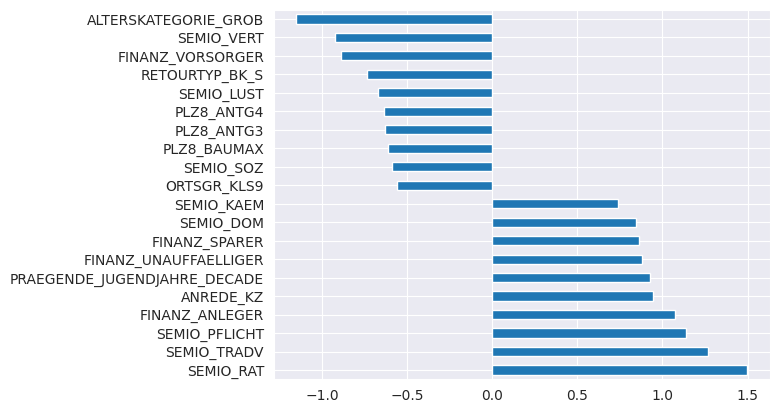

In [70]:
# credits to (https://katba-caroline.com/wp-content/uploads/2018/12/Identify_Customer_Segments-1.html#Step-2.3:-Interpret-Principal-Components)
# Visualize which features have the most significant positive and negative contributions to a specific cluster centroid
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
pca.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh')

# Plot cluster 4
plot_scaled_comparison(df_imputed, kmeans, 4)

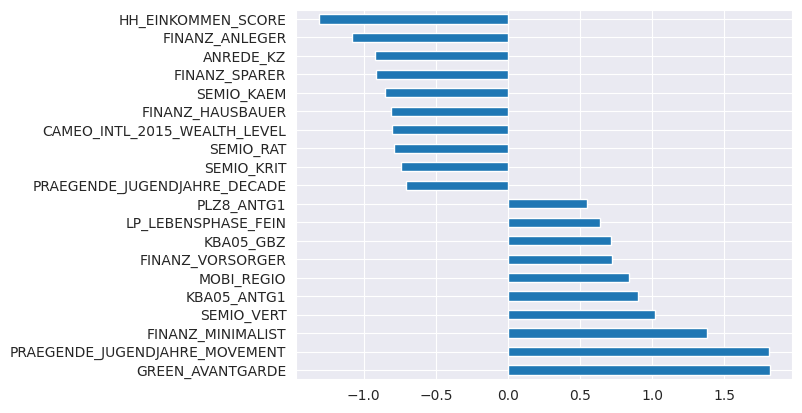

In [71]:
# Plot Cluster 18
plot_scaled_comparison(df_imputed, kmeans, 18)

### Discussion 3.3: Compare Customer Data to Demographics Data

**Review**:
- Loaded data from .csv files

        # Load in the general demographics data.
        azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

        # Load in the feature summary file.
        azdias_feat = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
- got an overview of the data
- parsed the data (converted missed values to NaNs)

        azdias_p = nan_missing_val(azdias, azdias_feat)
- dropped **columns** with too many missing values

        # Based on number of missing values in column: dividing the data into three subsets, subset that is below c_miss_threshold (in%) and subset that is above threshold
        c_miss_threshold = 15   # in %
        no_missing, c_name_low_miss, c_name_high_miss = mask_col_with_missing_values(c_name_miss_in_p, c_miss_threshold)

        # Get a list of column names to drop
        drop_col_list = c_name_high_miss.index.tolist()   # list with column names to drop

        # Drop the columns from the DataFrame
        azdias_p = azdias_p.drop(columns=drop_col_list)

- evaluate difference between rows with many and few missing values; dropped **rows** with too many missing values

        # Set a threshold value (not in %) for the number of missing values in each row.
        threshold_rows = 10
        subset_no_missing, subset_low_missing, subset_high_missing = divide_data_by_missing_values(azdias_p, threshold_rows)

        # Combining subsets with low amount and no missing values
        combined_df = pd.concat([subset_no_missing, subset_low_missing], ignore_index=True)
- encoded one binary categorical feature `OST_WEST_KZ` into dummy variables `{"W": 0, "O": 1}` and dropped the original feature; dropped multi-level categorical features

        ...
        combined_df["OST_WEST_KZ"] = combined_df["OST_WEST_KZ"].replace({"W": 0, "O": 1}).astype(int)
        ...
- encoded the mixed type feature `PRAEGENDE_JUGENDJAHRE` into `PRAEGENDE_JUGENDJAHRE_DECADAL` and `PRAEGENDE_JUGENDJAHRE_MOVEMENT` and dropped the original feature

        combined_df = engineer_praegende_jugendjahre(combined_df)
- encoded the mixed type feature `CAMEO_INTL_2015` into `CAMEO_INTL_2015_WEALTH_LEVEL` and `CAMEO_INTL_2015_HOUSEHOLD_TYPE` and dropped the original feature; dropped all other mixed-type features

        combined_df = engineer_cameo(combined_df)

        # OPTIONAL: I had to rename the dataframe to not interfere manual data cleaning on global level and the data cleaning function
        df = combined_df
        feat_sum = feat_summ

- applied PCA with default parameters to find the "elbow point"

        pca = PCA() # default is to keep all components and have an overall overview
        pca_general_population = pca.fit_transform(df_std);
    - Visualize the scree plot ("elbow point" = 6)

            scree_plot(explained_variance_ratio)
    - Visualize the cumulative variance plot (with 35 PC explain 90% of the variance in the data)

            cumulative_variance_plot(pca)
    - Decide on the number of principal components to keep (`PC = 6`: to keep is simple; `PC = 35`: to keep is complex; `PC = 18`: balance between complexity and accuracy)

- applied PCA with "elbow point" `PC = 28` as parameter input and `.fit_transform(df_std)` the data to reduce dimensionality:

        # Set the number of principal components (PC)
        pc_val = 28

        # Initialize the PCA object
        pca = PCA(n_components=pc_val)

        # Fit and transform the data.
        pca_general_population = pca.fit_transform(df_std)
    - Plot and discuss the first 5 features with the highest absolute variance of the first 3 PC

            # Plot the first 5 features with the highest absolute variance of the first three principal components
            plot_top_features_per_component(pca, df_std, 5, 2)
    - using the transformed data from PCA to fit `Kmeans()` clustering for different cluster counts `range(1, 30)` and plot average within-cluster distances to find the "elbow point":

            # Call function to perform the elbow analysis
            kmeans_clustering_analysis(pca_general_population, max_k=30)    # 1 to 30 clusters plotted to find the "elbow point"
    - re-fit the k-means model with the selected number ("elbow point") of clusters and obtain cluster predictions for the general population demographics data

            # Re-fit the K-Means model with the selected number of clusters
            # After observing the plot, k=10 is the optimal number of clusters.
            optimal_k = 21
            kmeans = KMeans(n_clusters=optimal_k, random_state=42)
            kmeans.fit(pca_general_population)

            # Obtain cluster predictions for general population
            cluster_labels = kmeans.predict(pca_general_population)   # labelling each data point by cluster

--------------------------------
- Switching to customer data

        # Load in the customer demographics data.
        customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")
        # Load in the feature summary file.
        azdias_feat = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
- IMPORTAND: keep the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (Hardcoded dropping of categorical features and column names must be used names which are identical to the general demographics data)

    - replacing missing values with the mean value of the column

            # Replacing all missing values with the mean value of the column
            df_customers_imputed = impute_missing_values(df_customers)

    - Apply already fitted sklearn StandardScaler() to the customer data

            # Apply feature scaling to the customer data
            # IMPORTANT: Apply already fitted sklearn StandardScaler() (=std_scaler) to the customer data
            df_std_customers = pd.DataFrame(std_scaler.transform(df_customers_imputed), columns=df_customers_imputed.columns)
    - Transform the customer data with PCA to reduce dimensionality (use the same/idetical module that has been initialized with the same parameters as for the general population data)

            ######### previously initializied code cell 990:4
            # Reducing dimensionality after selecting optimized number of principal components (PC) by elbow analysis of the scree plot and cumulative variance plot
            pc_val = 28
            pca = PCA(n_components=pc_val)
            # Fit and transform the data.
            pca_general_population = pca.fit_transform(df_std)
            ##########

            # Transform customer data (using the same "pca" as before, sine its already fitted to the general population data)
            df_std_customers_pca = pca.transform(df_std_customers)  # Reducing dimensionality of the customer data
    - Use previously fitted k-means model (kmeans_model_population) to obtain cluster predictions for the customer data

            # Create labels for the customer data that is already normalized by StandardScaler() and\
            # dimensions reduced by PCA
            customer_label = kmeans_model_population.predict(df_std_customers_pca)customer_label = kmeans_model_population.predict(df_std_customers_pca)
- get the cluster centroids and count the number of data points in each cluster within "demographic" and "customer" data and compare them in a plot
- pick one cluster of the under-represented clusters and one of the over-represented clusters; discuss the characteristics of the under-represented cluster and the over-represented cluster
 (demographic data is here the reference, since we are comparing it to the customer data)

### Discussion 3.3: Compare Customer Data to Demographics Data
One of the largest underrepresented clusters is **Cluster 4**.
**Targeting Strategies:** This study reveals Cluster 4 differs in terms of age distribution, personality, and financial behaviour. Marketing techniques might be developed to appeal to younger, more financially conscious people with a pragmatic, logical approach to purchase in order to get more consumers from this under-represented segment.

**Product Offerings:** Offering goods or services connected to investments, savings, or stability might draw more clients from this cluster as this cluster favours conventional values and demonstrates financial investment interest.

**Residential and Demographic Characteristics:** Based on the residential data, consumers seem to dwell in lower-density than average demographic regions. Thus, marketing aiming at suburban or rural regions might be more successful.

------------------------------------------------
One of the largest overrepresented clusters is **Cluster 18**.

Over-represented in the client base, Cluster 18 has a clear profile marked by lesser income, a minimalist attitude to money, great environmental awareness, and an ambitious, dreamful attitude. Those in this cluster live in suburban regions, have simpler financial items of choice, and care about sustainability. Targeting this population with environmentally friendly products, stressing affordability, and marketing that appeals to ambitions and environmental conscience can help businesses to use these insights.




(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.